# HW3: Pedro Armengol

# 1) Import Packages and Read CSV

In [133]:
from __future__ import division
import matplotlib.pyplot as plt
import plotly.plotly as py  
import pandas as pd
import numpy as np
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier

import random
import pylab as pl
import matplotlib.pyplot as plt
from scipy import optimize
import time
import seaborn as sns

%matplotlib inline

path = "/Users/Usuario/Documents/Chicago/CS_ML/HW3/Data/"
data = "credit-data.csv"

In [134]:
credit_df = pd.read_csv(path+data)

## 2) DESCRIPTIVE STATISTICS

In [135]:
def exploratory_df(df):
    #Number of Observation for each columns
    count = df.count()
    correlations = df.corr()
    
    return count,correlations

In [181]:
count, correlations = exploratory_df(credit_df)

In [137]:
count

PersonID                                150000
SeriousDlqin2yrs                        150000
RevolvingUtilizationOfUnsecuredLines    150000
age                                     150000
zipcode                                 150000
NumberOfTime30-59DaysPastDueNotWorse    150000
DebtRatio                               150000
MonthlyIncome                           120269
NumberOfOpenCreditLinesAndLoans         150000
NumberOfTimes90DaysLate                 150000
NumberRealEstateLoansOrLines            150000
NumberOfTime60-89DaysPastDueNotWorse    150000
NumberOfDependents                      146076
dtype: int64

The database have 150,000 observations, where every observation is a creditholder. Some variables have missing values: NA (for example, MonthlyIncome has almost 3,000 NA's). There would be neccesary a data imputation mechanism in order to build a balace dataframe for the predictions.

## Correlation Matrix

In [138]:
correlations

PersonID  SeriousDlqin2yrs  \
PersonID                              1.000000          0.002801   
SeriousDlqin2yrs                      0.002801          1.000000   
RevolvingUtilizationOfUnsecuredLines  0.002372         -0.001802   
age                                   0.004403         -0.115386   
zipcode                              -0.002721          0.005103   
NumberOfTime30-59DaysPastDueNotWorse -0.000571          0.125587   
DebtRatio                            -0.002906         -0.007602   
MonthlyIncome                         0.002632         -0.019746   
NumberOfOpenCreditLinesAndLoans       0.004586         -0.029669   
NumberOfTimes90DaysLate              -0.001104          0.117175   
NumberRealEstateLoansOrLines         -0.000666         -0.007038   
NumberOfTime60-89DaysPastDueNotWorse -0.000777          0.102261   
NumberOfDependents                   -0.000055          0.046048   

                                      RevolvingUtilizationOfUnsecuredLines  \
PersonID                                                          0.002372   
SeriousDlqin2yrs                                                 -0.001802   
RevolvingUtilizationOfUnsecuredLines                              1.000000   
age                                                              -0.005898   
zipcode                                                          -0.003571   
NumberOfTime30-59DaysPastDueNotWorse                             -0.001314   
DebtRatio                                                         0.003961   
MonthlyIncome                                                     0.007124   
NumberOfOpenCreditLinesAndLoans                                  -0.011281   
NumberOfTimes90DaysLate                                          -0.001061   
NumberRealEstateLoansOrLines                                      0.006235   
NumberOfTime60-89DaysPastDueNotWorse                             -0.001048   
NumberOfDependents                                                0.001557   

                                           age   zipcode  \
PersonID                              0.004403 -0.002721   
SeriousDlqin2yrs                     -0.115386  0.005103   
RevolvingUtilizationOfUnsecuredLines -0.005898 -0.003571   
age                                   1.000000  0.002590   
zipcode                               0.002590  1.000000   
NumberOfTime30-59DaysPastDueNotWorse -0.062995  0.007429   
DebtRatio                             0.024188  0.001458   
MonthlyIncome                         0.037717  0.002070   
NumberOfOpenCreditLinesAndLoans       0.147705 -0.003609   
NumberOfTimes90DaysLate              -0.061005  0.007543   
NumberRealEstateLoansOrLines          0.033150 -0.001345   
NumberOfTime60-89DaysPastDueNotWorse -0.057159  0.007619   
NumberOfDependents                   -0.213303 -0.003511   

                                      NumberOfTime30-59DaysPastDueNotWorse  \
PersonID                                                         -0.000571   
SeriousDlqin2yrs                                                  0.125587   
RevolvingUtilizationOfUnsecuredLines                             -0.001314   
age                                                              -0.062995   
zipcode                                                           0.007429   
NumberOfTime30-59DaysPastDueNotWorse                              1.000000   
DebtRatio                                                        -0.006542   
MonthlyIncome                                                    -0.010217   
NumberOfOpenCreditLinesAndLoans                                  -0.055312   
NumberOfTimes90DaysLate                                           0.983603   
NumberRealEstateLoansOrLines                                     -0.030565   
NumberOfTime60-89DaysPastDueNotWorse                              0.987005   
NumberOfDependents                                               -0.002680   

                                      DebtRatio  MonthlyIn

After running a correlation matrix, is easy to see that there are not strong correlations (negative nor positive) between our variable of interest (SeriousDlqin2yr) under the standar of $p > .6$. However, given that SeriousDlqin2yr is a dummy, some correlations are worth to note: first there is a negative correlation between age and propensity to suffer "financial distress". Second, there is a positive correlation between financial distress and NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate and NumberOfTime60-89DaysPastDueNotWorse. In other words, sort term loans debt payment delays are positively associated to long term (2 years) financial distress.




### Delimit X and y based on the correlation analysis

In [219]:
X = ["age","NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate","NumberOfTime60-89DaysPastDueNotWorse"]

In [220]:
y = ["SeriousDlqin2yrs"]

In [141]:
def exploratory_variables(X,y,df):
    ### For now just work with independent variables that take the value 1 or 0.
    #Create table of means
    table_means = df.groupby(y)[X].mean()
    #Create Histograms of distributions
    
    for i in X:
        name = [i]
        
        plt.figure(1)
        plt.subplot(221)
        plt.title('Histogram of {0} ({1}==0)'.format(i,y[0]))
        df[name[0]][df[y[0]] == 0].hist()
        plt.ylabel('Frequency')
    
        plt.subplot(222)
        plt.title('Histogram of {0} ({1}==1)'.format(i,y[0]))
        df[name[0]][df[y[0]] == 1].hist()
        plt.ylabel('Frequency')
        plt.subplots_adjust(top=4, bottom=0.08, left=0.30, right=2.0, hspace=3.0,wspace=1.0)
        
        plt.show()
        plt.clf()
    

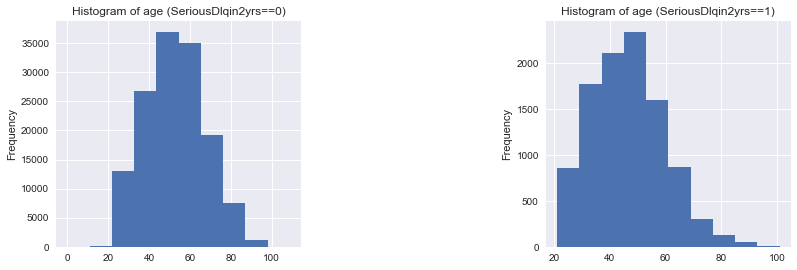

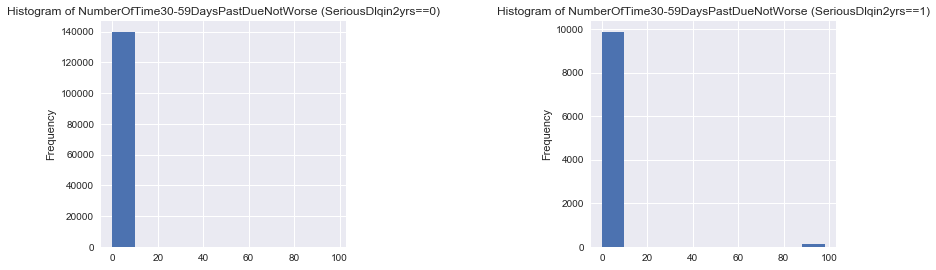

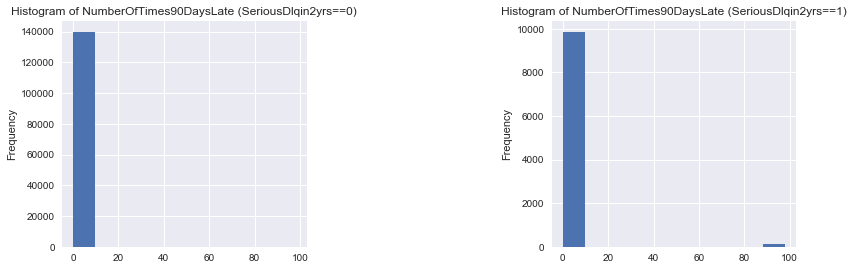

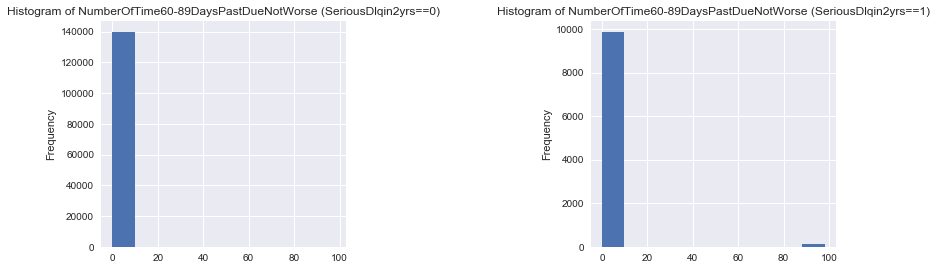

In [142]:
exploratory_variables(X,y,credit_df)

In this table, we show the difference in means between the people that experienced financial distress (Serious Dlqin2yrs == 1) and the ones that not. In general, the people that experienced financial distress have relatively less revolving utilization of unsecured lines. The same group is relatively younger, have a smaller debt ration (that is reasonable given less access to loans) and, also, a smaller monthly income. In the same direction, the number of open credits of the "financial distress" group is smaller and the other group. The number of dependants is higher in the "financial distress" group as well. 

### Distributions of Key Variables

The age distribution of the people with "financial distress" is relatively more positively skewed that the people without it. In other words, the biggest chunk of people with "financial distress" is concentrated in early ages,  with a relative small incidence of cases beyond the $60$ years old.

In [143]:
credit_df["monthly_categ"] = pd.qcut(credit_df["MonthlyIncome"], 5, labels=["Very Low","Low","Middle","Middle High","Very High"])

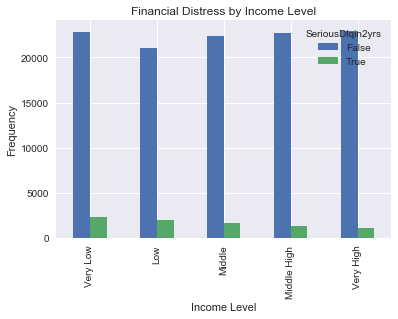

In [144]:
# Barplot of Income Level and Number of Dependants grouped by Financial Distress (True or False)

pd.crosstab(credit_df.monthly_categ, credit_df.SeriousDlqin2yrs.astype(bool)).plot(kind='bar')
plt.title('Financial Distress by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Frequency')

plt.show()


In the previous graph, there can be observe an slighly trend to suffer less financial distress with higher income levels. 

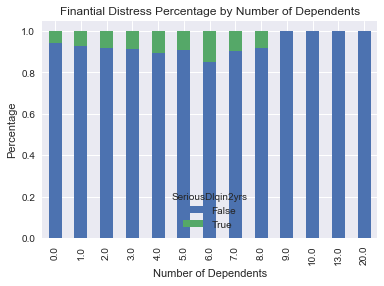

In [145]:
distress_dependents = pd.crosstab(credit_df.NumberOfDependents, credit_df.SeriousDlqin2yrs.astype(bool))
distress_dependents.div(distress_dependents.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Finantial Distress Percentage by Number of Dependents')
plt.xlabel('Number of Dependents')
plt.ylabel('Percentage')

The relationship between number of dependents and a higher percentage of finantial distress is not completly clear. However, there can be observe an increasing trend in the proportion of people with financial distress with the increment of the number of dependents in the range between 0 and 7 (the vast mayority of the sample).

## 3) Pre - Process Data

In [146]:

def filling_missing(X,y,df):
    '''
    Receive a data frame with missing values and return a data frame without missing values
    Input:s
        Data frame with Nan's
    Output:
        Data frame without Nan's
    
    '''
    X = df[X]
    y = df[y]
    #Deal with NA's in the predictors
    for c in X.columns:
        if X[c].count() < len(X):
            missing_perc = ((len(X) - X[c].count()) / float(len(X))) * 100.0
            print("%.1f%% missing from: Column %s" %(missing_perc, c))
            #Deal with continuos variables
            if X[c].dtype == 'int64':
                X[c] = X[c].fillna(X[c].mean())
            #There is not an easy way to extrapolate string variables (ID/categories) so we are 
            #going to delete them
            X[c] = X[c].dropna()
            
    #Deal with in the predicted variable (If there are NA's we drop them because we don´t want to play
    #with the most important variable in the dataset).
    for c in y.columns: 
        if y[c].count() < len(y):
            missing_perc = ((len(y) - y[c].count()) / float(len(y))) * 100.0
            print("%.1f%% missing from: Column %s" %(missing_perc, "Independent variable"))
            y = y[c].dropna()
        
    return X, y 




## 4) Generate Features/Predictors

In [147]:
def categorize_continuos(var,bins,df):

    '''
    Receive a continuos variable and discretaize it. After, the variable is merge with the database of interest.
    Input:
        var: string (variable name)
        bins: int (number of cuts in the variable)
        df: dataframe (where the continuos variable is located and where the discrete variable will be merge)
    Output:
        df: dataframe (with the categorical variable)
    
    '''
    df["{0}_categ".format(var)] = pd.cut(df[var],bins)
    
    return df

def categorical_dummy(var,df):

    '''
    Receive a categorical variable and convert it into several dummies (one for each category). After, the dummies are merge 
    with the databse of interest
    Input:
        variable: Data frame column (categorical variable)
        df: dataframe      
    Output:
        df: dataframe (with the dummy variables)
        
    '''
    dummies = pd.get_dummies(df[var])
    
    n = 0
    for i in dummies:
        n += 1
        name = "dummy{0}{1}".format(var,n)
        dummies = dummies.rename(columns = {i:name})
    
    df = df.merge(dummies, left_index = True, right_index = True)   
    
    return df




### Processing Data before classification




We will build the model just with the 4 variables that have the higher correlation coeficient (in absolute value) with our variable to predict (SeriousDlqin2yrs). Of those we are discretazing 3 of them (see list covariates).

In [148]:
list_dummies = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate","NumberOfTime60-89DaysPastDueNotWorse"]


In [149]:
list_dummies



['NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse']

In [151]:
def pre_process_data(X,y,df,list_dummies):
    '''
    Inputs:
        X: List
        y: List
        list_dummies: List
        df: Dataframe
    Outputs:
        X: Dataframe
        y: Dataframe
    '''
    #Parameter: number of bins for the buckets of the categorical variables
    bins = 10
    
    #Deal with missing values
    X,y = filling_missing(X,y,df)
    #Categorize continuos and create dummies of each category
    for i in list_dummies:
        X = categorize_continuos(i,bins,X)
        X = categorical_dummy(i,X)
    #Drop the initial variables (that are already a bunch of dummies)
    for i in list_dummies:
        X.drop([i,"{0}_categ".format(i)],axis=1, inplace=True)
    return X,y




## 5) Classifiers Estimation (The following code is taken from the Rayid's Ghani Magic Loop)


### Define combinations of models and parameters

In [162]:
def define_clfs_params():

    clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
        'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
        'DT': DecisionTreeClassifier(),
        'KNN': KNeighborsClassifier(n_neighbors=3),
        'BAG': BaggingClassifier(n_estimators = 5, max_samples=0.65, max_features=1.0)
            }

    grid = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']},
    'BAG' :{"n_estimators": [5,8,10,15], "max_samples": [0.65,1], "max_features": [1.0]}

           }
    

    return clfs, grid



### Define functions of efficiency evaluation (precision and recall)

In [169]:
def generate_binary_at_k(y_scores, k): 
    cutoff_index = int(len(y_scores) * (k / 100.0))
    test_predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return test_predictions_binary

def precision_at_k(y_true, y_scores, k):
    preds_at_k = generate_binary_at_k(y_scores, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    precision = precision_score(y_true, preds_at_k)
    return precision

def plot_precision_recall_n(y_true, y_prob, model_name):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    #plt.savefig(name)
    plt.show()

### Define Loop of classifiers

In [200]:
def clf_loop(models_to_run, clfs, grid, X, y):
    results_df =  pd.DataFrame(columns=('model_type','clf', 'parameters', 'auc-roc','p_at_5', 'p_at_10', 'p_at_20'))
    for n in range(1, 2):
        # create training and valdation sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        for index,clf in enumerate([clfs[x] for x in models_to_run]):
            print("clf")
            print(clf)
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                print("parameters")
                print(p)
                clf.set_params(**p)
                y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                # you can also store the model, feature importances, and prediction scores
                # we're only storing the metrics for now
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                print(len(y_pred_probs_sorted))
                print(len(y_test_sorted))
                results_df.loc[len(results_df)] = [models_to_run[index],clf, p,
                                                    roc_auc_score(y_test, y_pred_probs),
                                                    precision_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                    precision_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                    precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0)]
                
                plot_precision_recall_n(y_test,y_pred_probs,clf)
         
    results_df.to_csv("/Users/Usuario/Documents/Chicago/CS_ML/HW3/Data/results_df.csv")
    return results_df

In [201]:

def results(X,y):
    
    clfs, grid = define_clfs_params()
    models_to_run=['RF','AB','LR', 'SVM', 'GB', 'DT','KNN',"BAG"]  
    results_df = clf_loop(models_to_run, clfs,grid, X,y)
    return results_df
    
    
    
    

# The Estimation

We will run the classification models with $SeriousDlqin2yrs$ as the depedent variables and the dummies of the section "Processing Data before classification" as indepent variables.

Is important to recall, that the other variables $MonthlyIncome$, $NumberOfDependents$, $DebtRatio$, and so on where added to the model without accuracy gains (see next section).

/Users/Usuario/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



clf
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
parameters
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10}
37500
37500


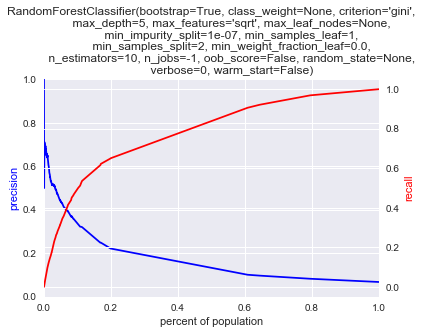

parameters
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
37500
37500


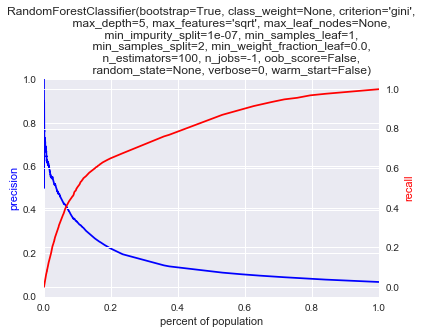

parameters
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10}
37500
37500


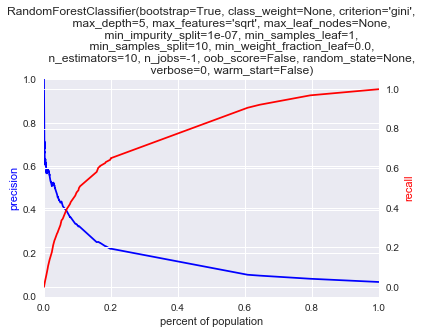

parameters
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
37500
37500


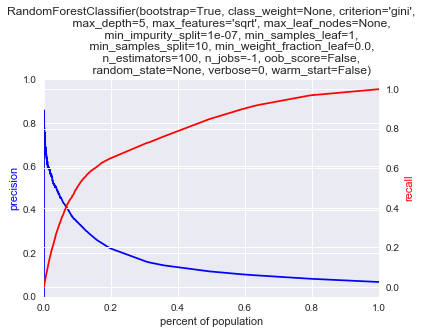

parameters
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10}
37500
37500


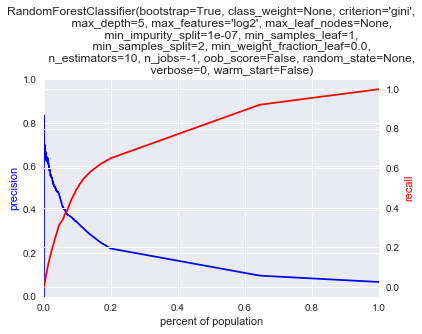

parameters
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
37500
37500


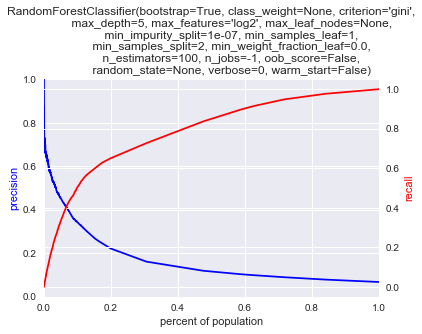

parameters
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10}
37500
37500


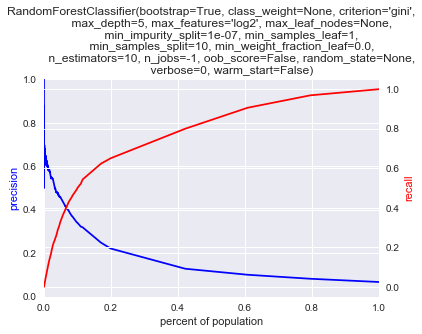

parameters
{'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}
37500
37500


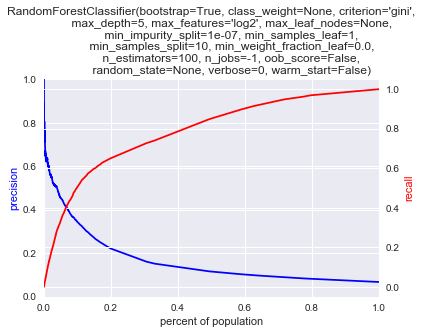

parameters
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10}
37500
37500


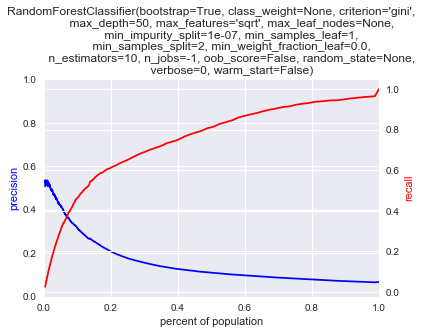

parameters
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
37500
37500


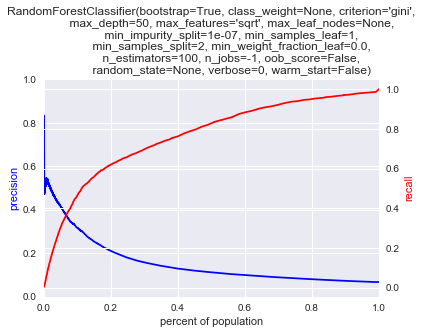

parameters
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10}
37500
37500


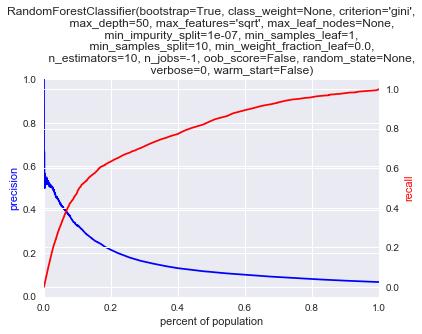

parameters
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100}
37500
37500


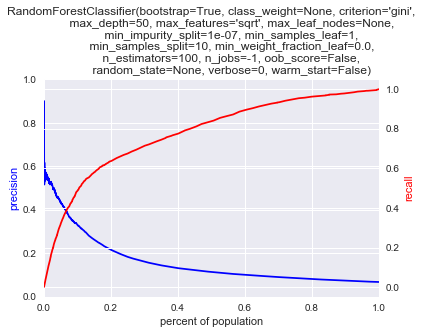

parameters
{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10}
37500
37500


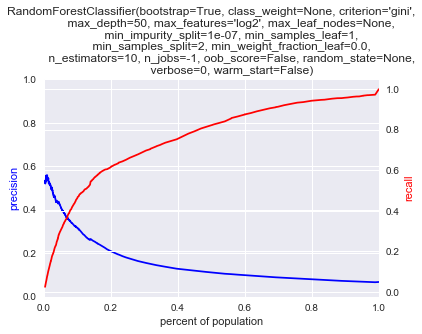

parameters
{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
37500
37500


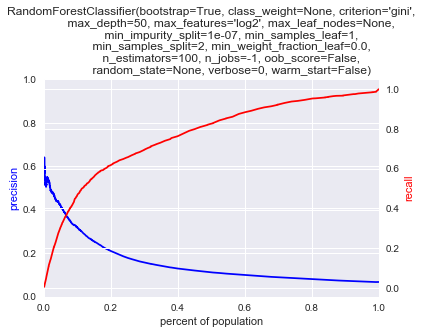

parameters
{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10}
37500
37500


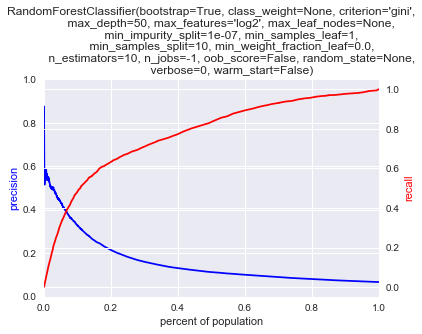

parameters
{'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100}
37500
37500


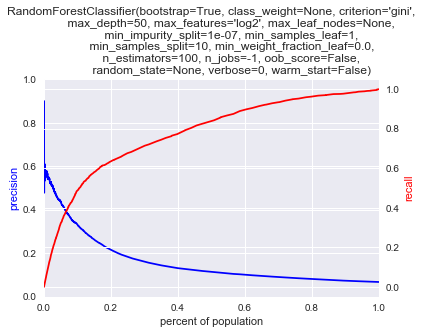

clf
AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=None)
parameters
{'algorithm': 'SAMME', 'n_estimators': 1}
37500
37500


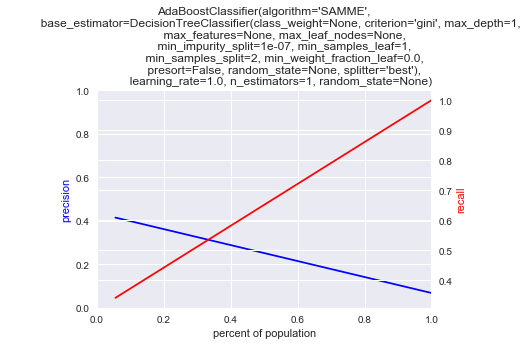

parameters
{'algorithm': 'SAMME', 'n_estimators': 10}
37500
37500


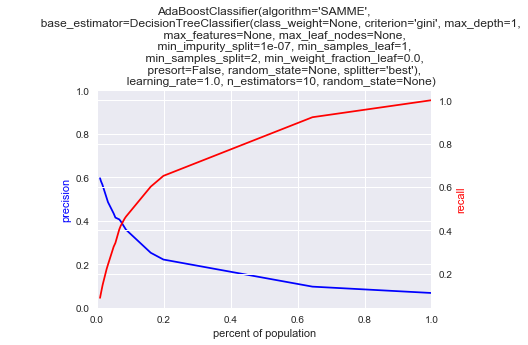

parameters
{'algorithm': 'SAMME', 'n_estimators': 100}
37500
37500


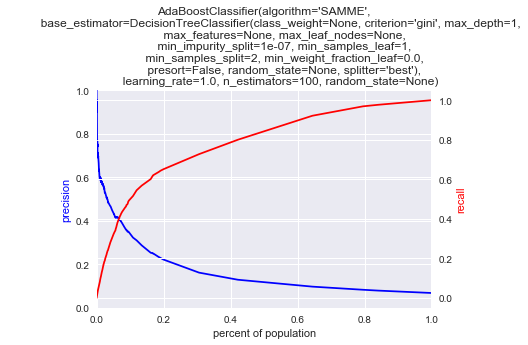

parameters
{'algorithm': 'SAMME', 'n_estimators': 1000}
37500
37500


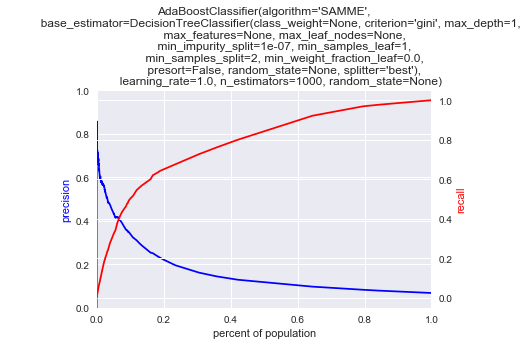

parameters
{'algorithm': 'SAMME', 'n_estimators': 10000}
37500
37500


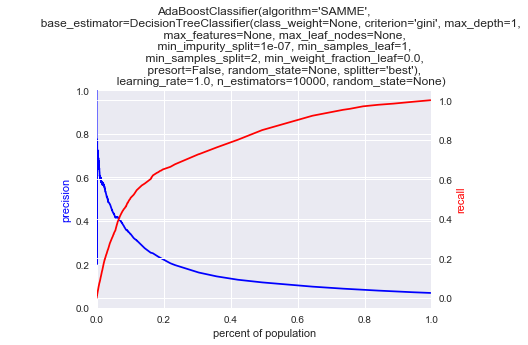

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 1}
37500
37500


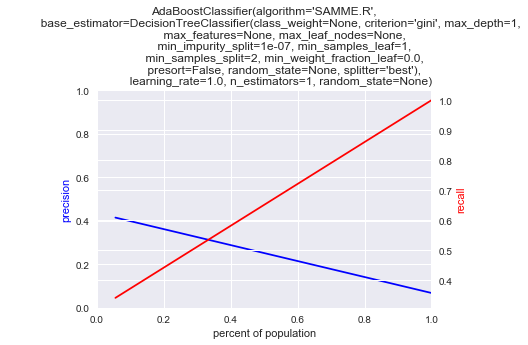

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 10}
37500
37500


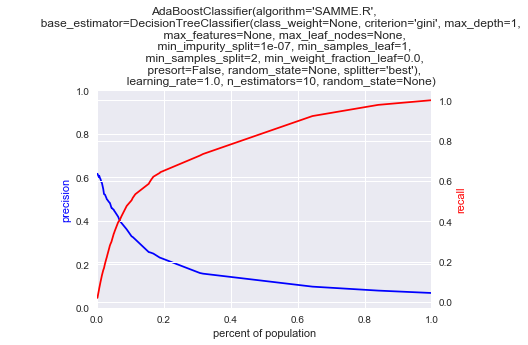

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 100}
37500
37500


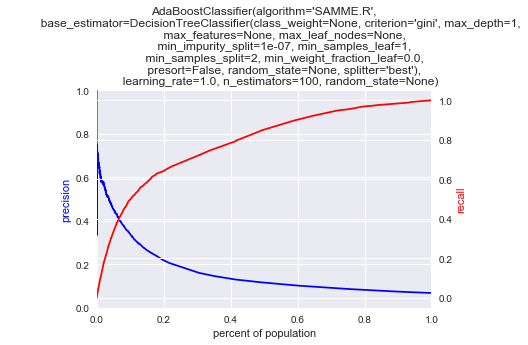

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 1000}
37500
37500


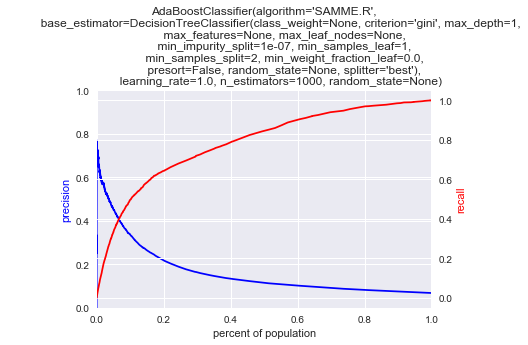

parameters
{'algorithm': 'SAMME.R', 'n_estimators': 10000}
37500
37500


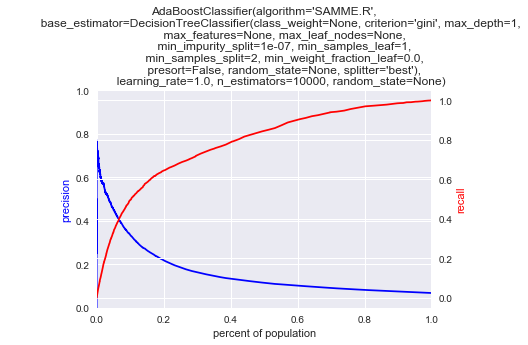

clf
LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
parameters
{'C': 1e-05, 'penalty': 'l1'}
37500
37500


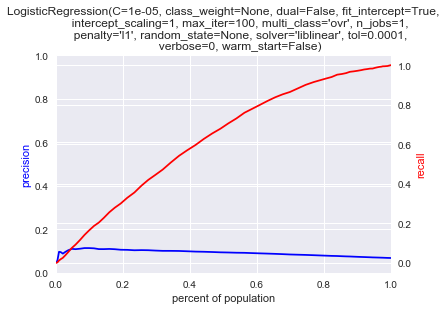

parameters
{'C': 1e-05, 'penalty': 'l2'}
37500
37500


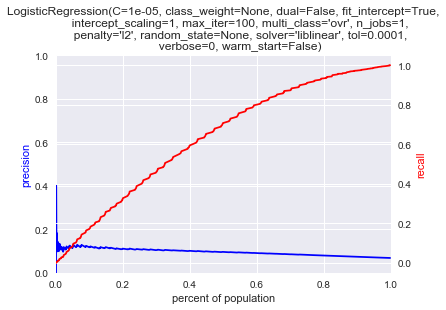

parameters
{'C': 0.001, 'penalty': 'l1'}
37500
37500


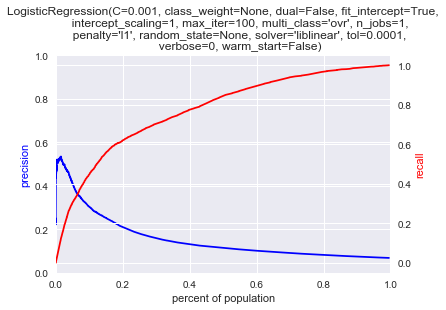

parameters
{'C': 0.001, 'penalty': 'l2'}
37500
37500


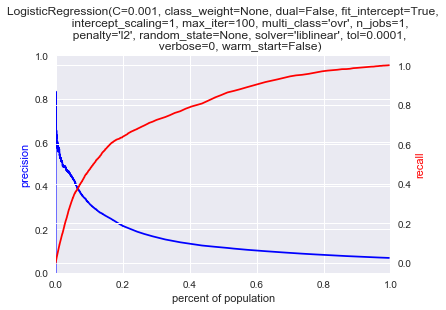

parameters
{'C': 0.1, 'penalty': 'l1'}
37500
37500


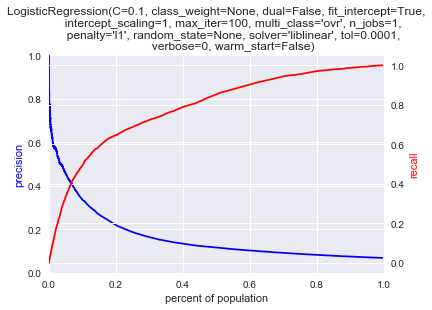

parameters
{'C': 0.1, 'penalty': 'l2'}
37500
37500


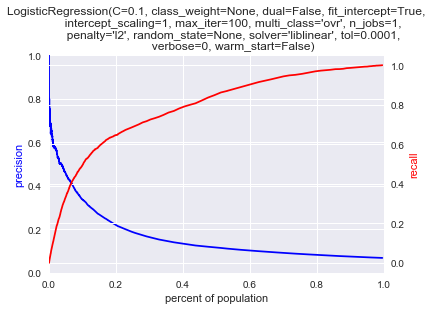

parameters
{'C': 1, 'penalty': 'l1'}
37500
37500


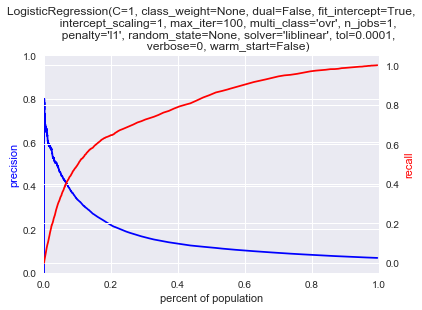

parameters
{'C': 1, 'penalty': 'l2'}
37500
37500


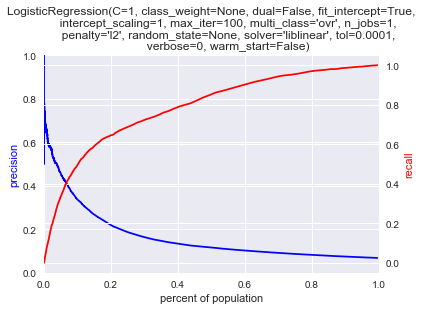

parameters
{'C': 10, 'penalty': 'l1'}
37500
37500


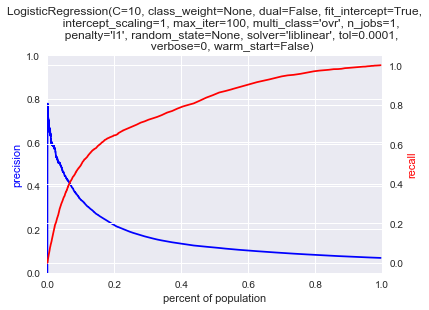

parameters
{'C': 10, 'penalty': 'l2'}
37500
37500


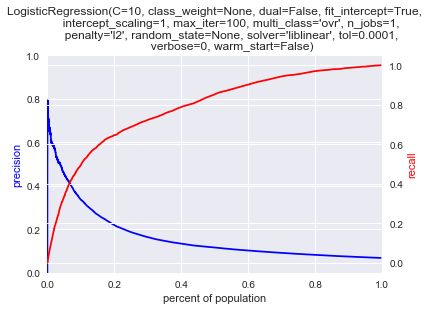

clf
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)
parameters
{'C': 1e-05, 'kernel': 'linear'}
37500
37500


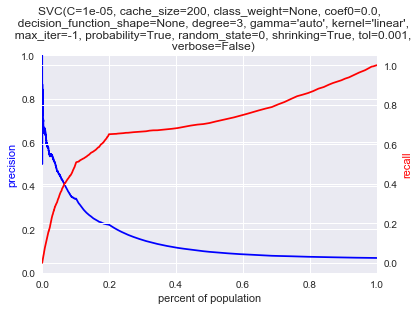

parameters
{'C': 0.0001, 'kernel': 'linear'}
37500
37500


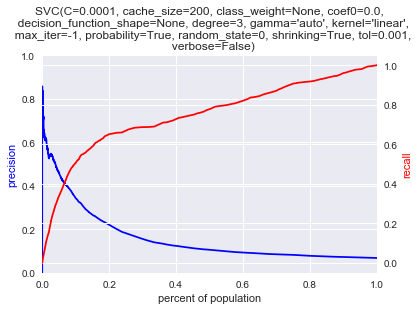

parameters
{'C': 0.001, 'kernel': 'linear'}
37500
37500


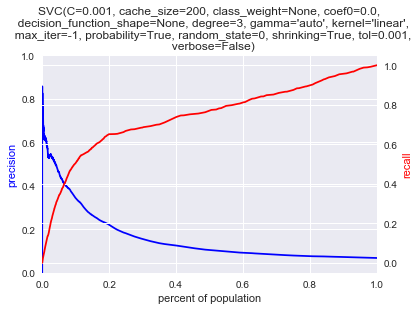

parameters
{'C': 0.01, 'kernel': 'linear'}
37500
37500


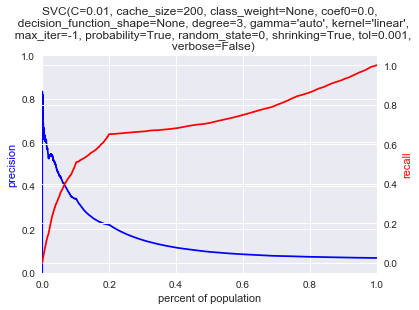

parameters
{'C': 0.1, 'kernel': 'linear'}
37500
37500


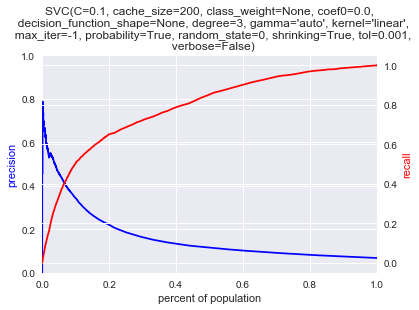

parameters
{'C': 1, 'kernel': 'linear'}
37500
37500


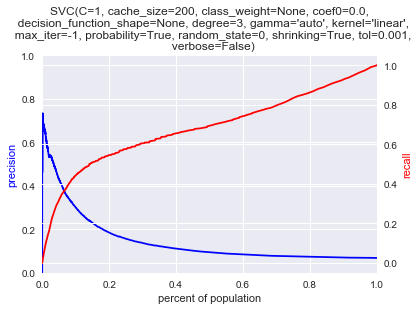

parameters
{'C': 10, 'kernel': 'linear'}
37500
37500


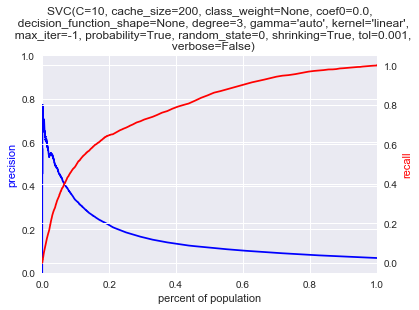

clf
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=10, presort='auto', random_state=None,
              subsample=0.5, verbose=0, warm_start=False)
parameters
{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.1}
37500
37500


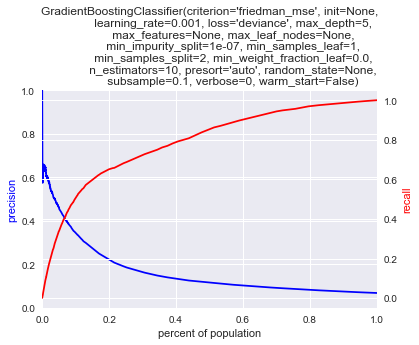

parameters
{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}
37500
37500


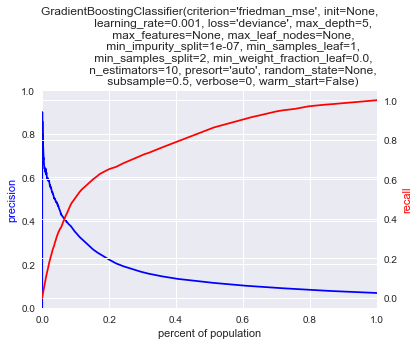

parameters
{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 10, 'subsample': 1.0}
37500
37500


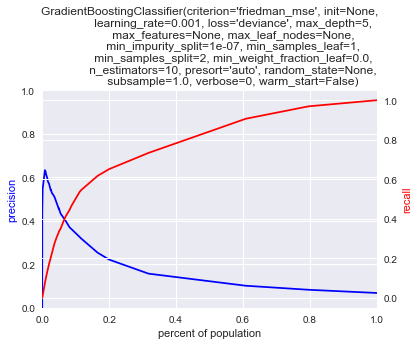

parameters
{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}
37500
37500


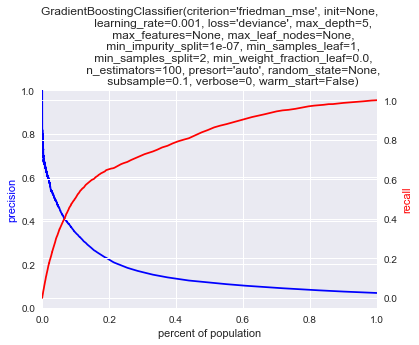

parameters
{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
37500
37500


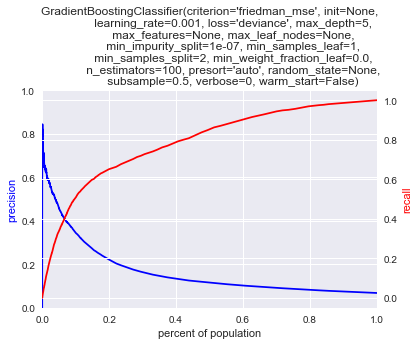

parameters
{'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
37500
37500


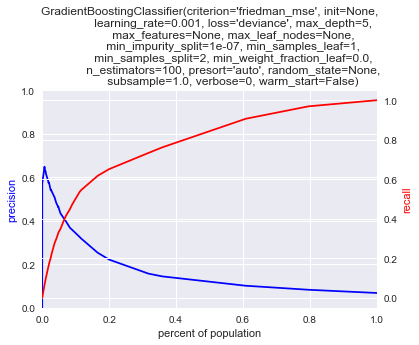

parameters
{'learning_rate': 0.001, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.1}
37500
37500


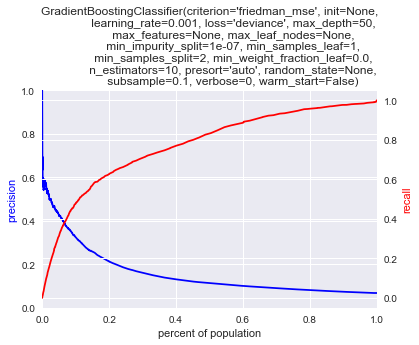

parameters
{'learning_rate': 0.001, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.5}
37500
37500


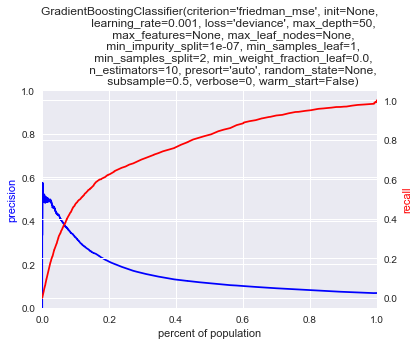

parameters
{'learning_rate': 0.001, 'max_depth': 50, 'n_estimators': 10, 'subsample': 1.0}
37500
37500


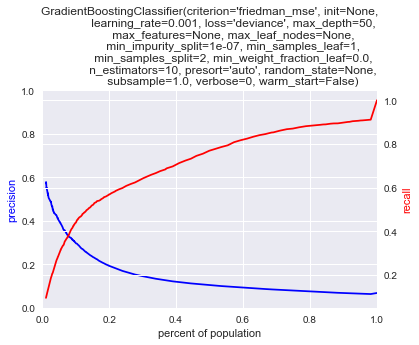

parameters
{'learning_rate': 0.001, 'max_depth': 50, 'n_estimators': 100, 'subsample': 0.1}
37500
37500


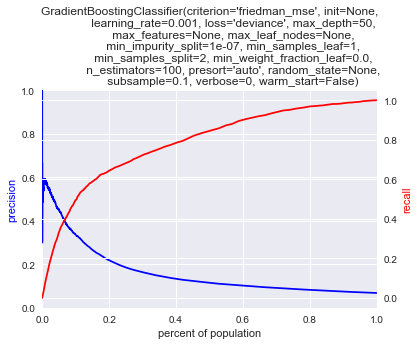

parameters
{'learning_rate': 0.001, 'max_depth': 50, 'n_estimators': 100, 'subsample': 0.5}
37500
37500


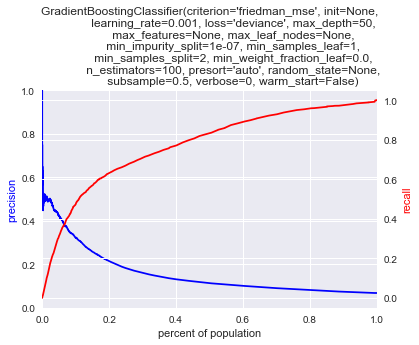

parameters
{'learning_rate': 0.001, 'max_depth': 50, 'n_estimators': 100, 'subsample': 1.0}
37500
37500


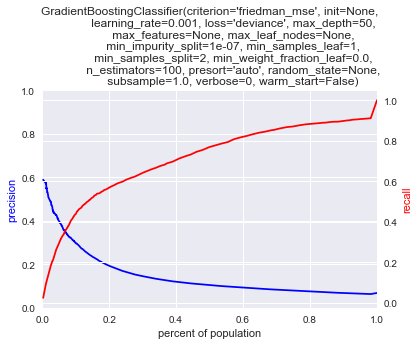

parameters
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.1}
37500
37500


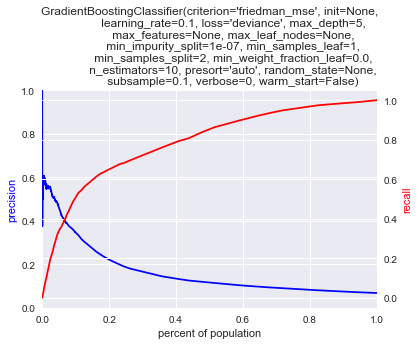

parameters
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}
37500
37500


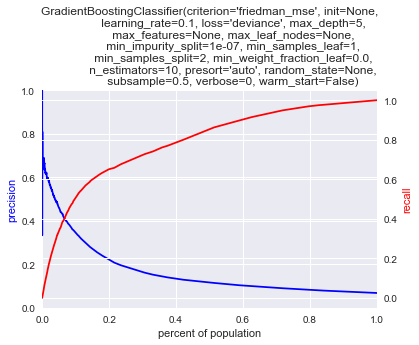

parameters
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10, 'subsample': 1.0}
37500
37500


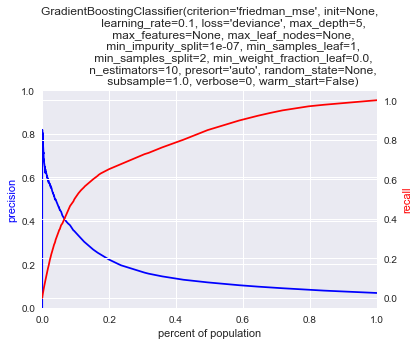

parameters
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}
37500
37500


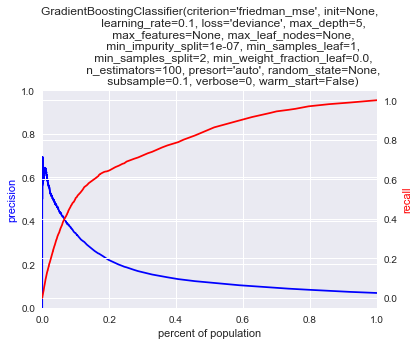

parameters
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
37500
37500


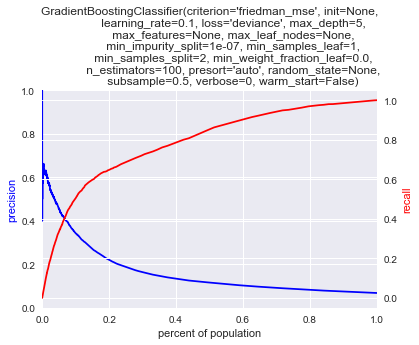

parameters
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
37500
37500


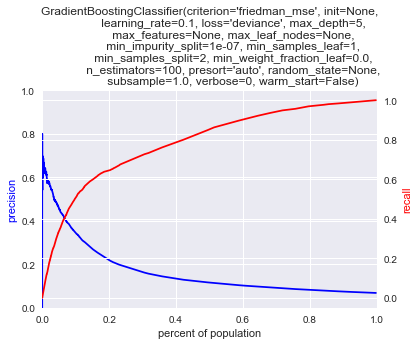

parameters
{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.1}
37500
37500


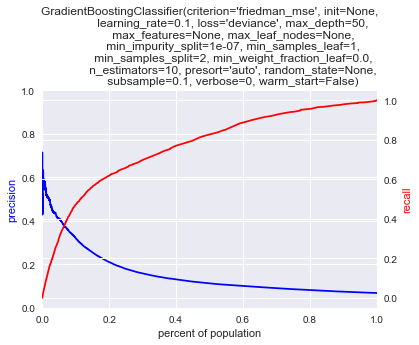

parameters
{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.5}
37500
37500


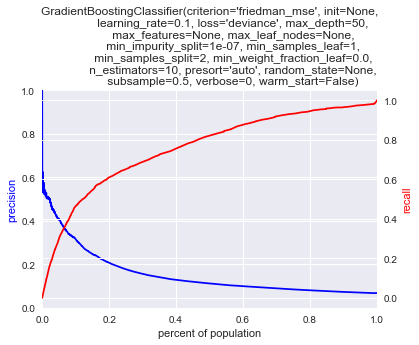

parameters
{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 10, 'subsample': 1.0}
37500
37500


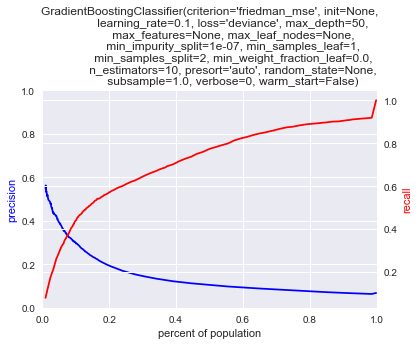

parameters
{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100, 'subsample': 0.1}
37500
37500


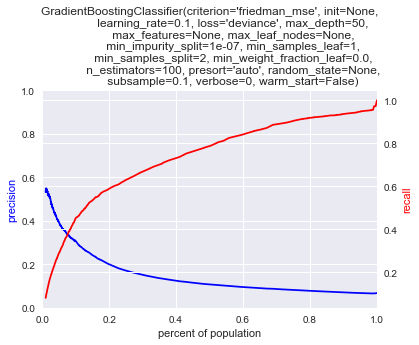

parameters
{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100, 'subsample': 0.5}
37500
37500


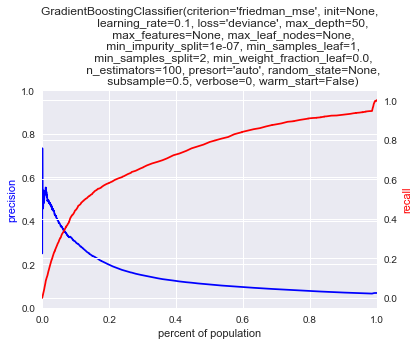

parameters
{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100, 'subsample': 1.0}
37500
37500


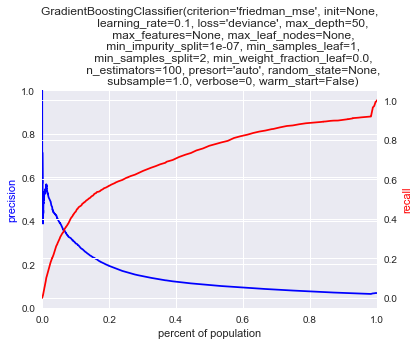

parameters
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.1}
37500
37500


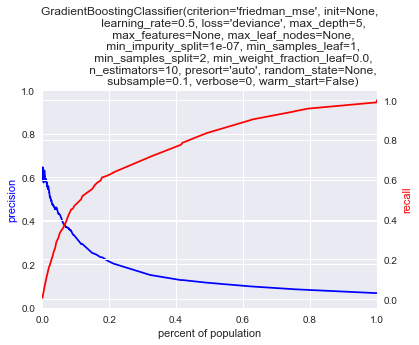

parameters
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10, 'subsample': 0.5}
37500
37500


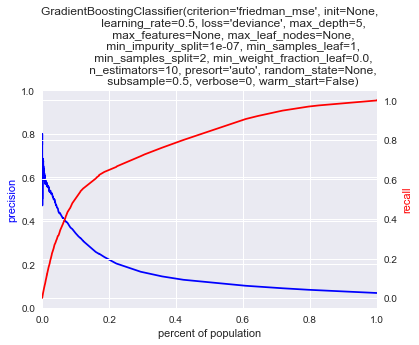

parameters
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 10, 'subsample': 1.0}
37500
37500


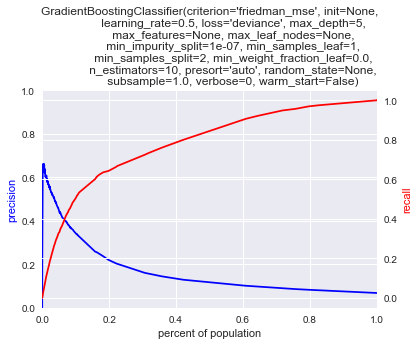

parameters
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.1}
37500
37500


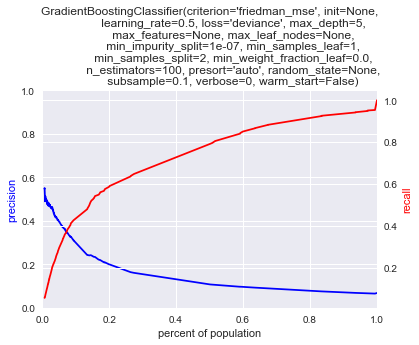

parameters
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
37500
37500


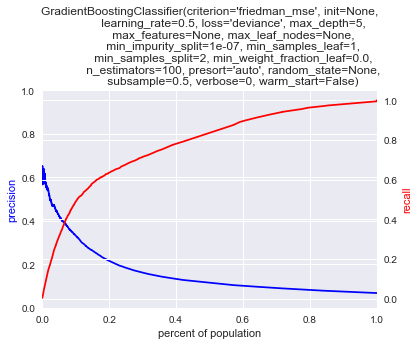

parameters
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
37500
37500


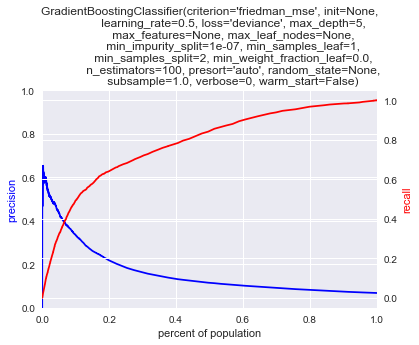

parameters
{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.1}
37500
37500


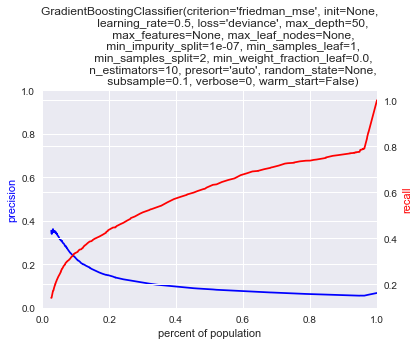

parameters
{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 10, 'subsample': 0.5}
37500
37500


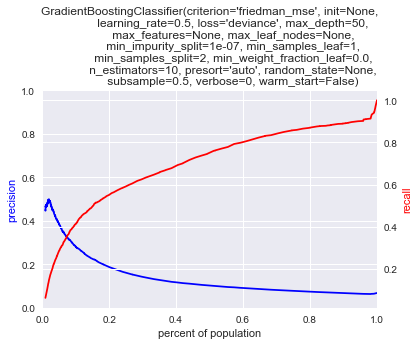

parameters
{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 10, 'subsample': 1.0}
37500
37500


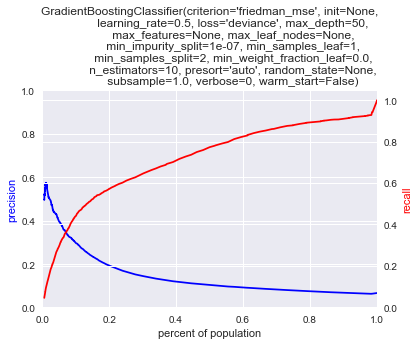

parameters
{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 100, 'subsample': 0.1}
37500
37500


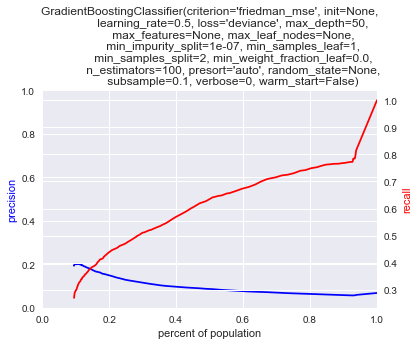

parameters
{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 100, 'subsample': 0.5}
37500
37500


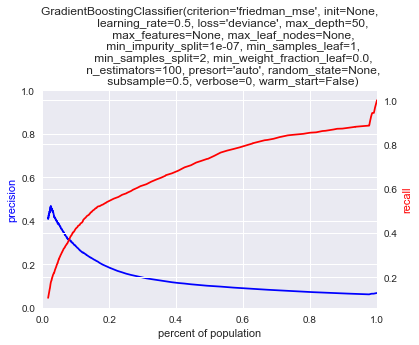

parameters
{'learning_rate': 0.5, 'max_depth': 50, 'n_estimators': 100, 'subsample': 1.0}
37500
37500


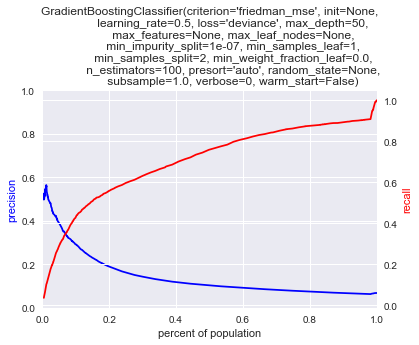

clf
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
parameters
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


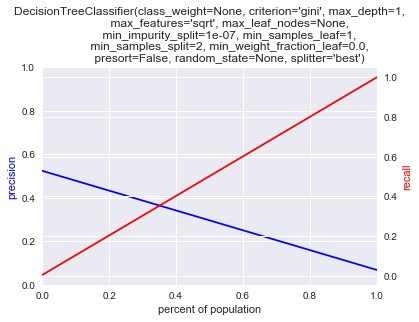

parameters
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


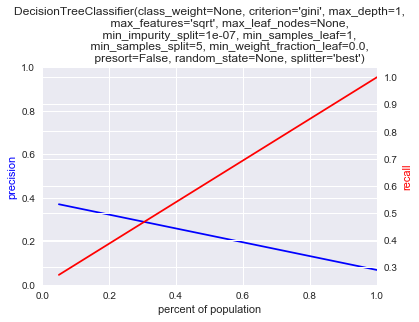

parameters
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


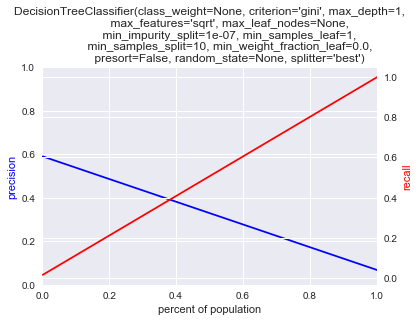

parameters
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


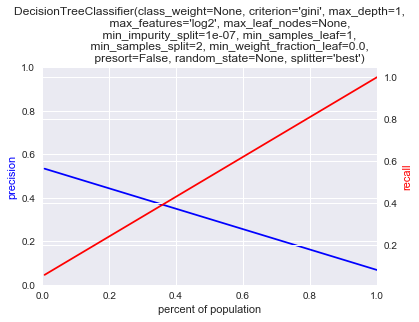

parameters
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


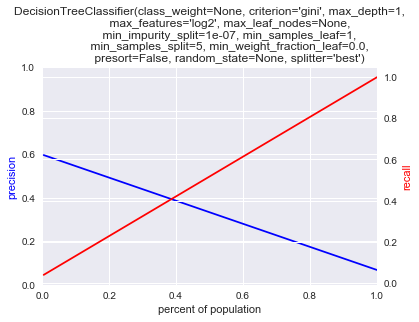

parameters
{'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


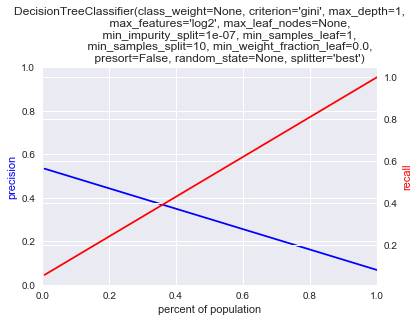

parameters
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


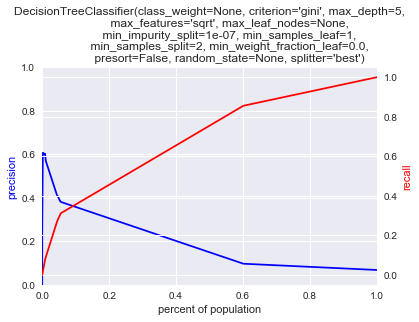

parameters
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


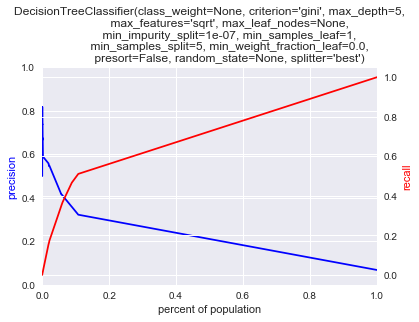

parameters
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


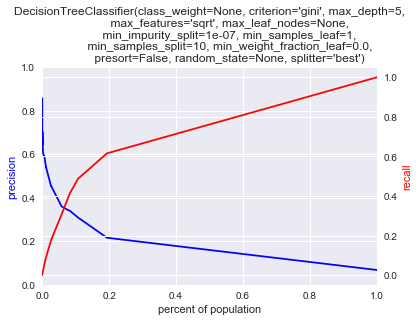

parameters
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


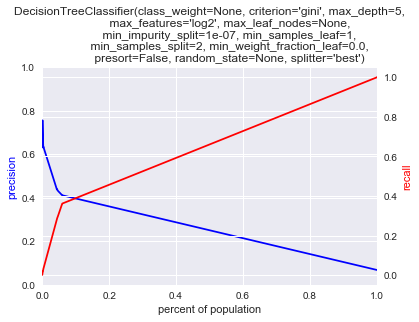

parameters
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


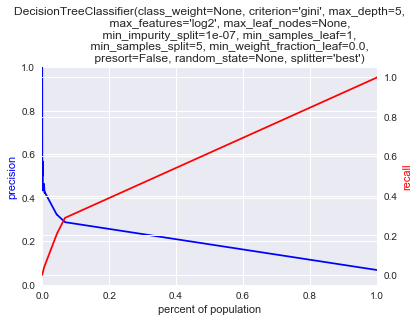

parameters
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


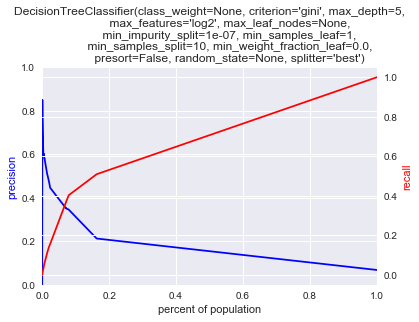

parameters
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


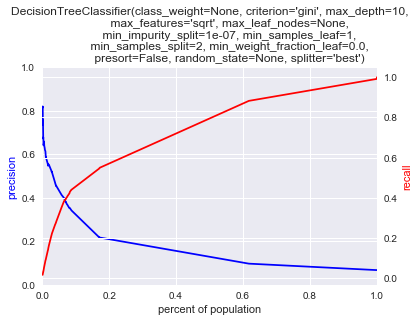

parameters
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


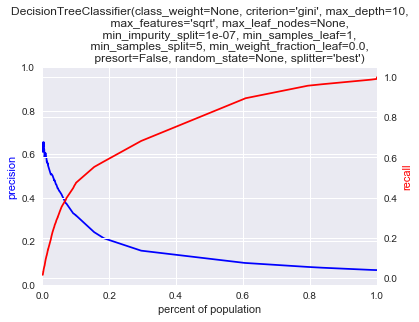

parameters
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


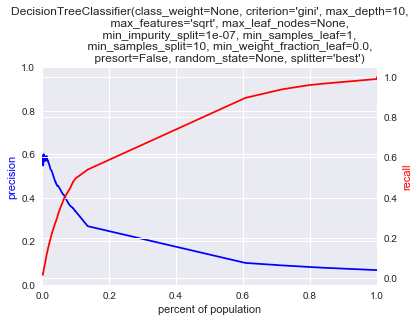

parameters
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


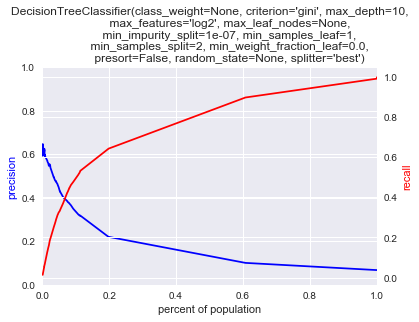

parameters
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


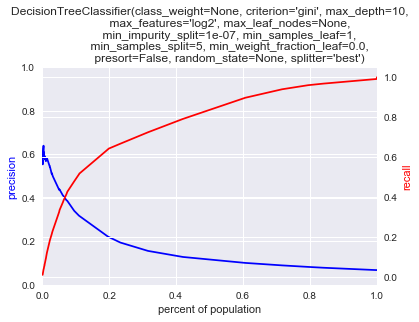

parameters
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


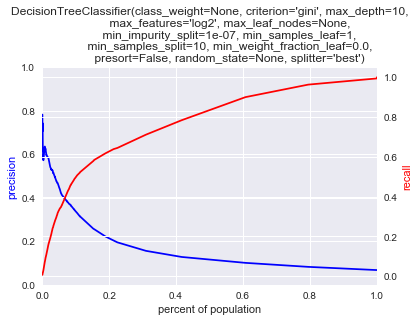

parameters
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


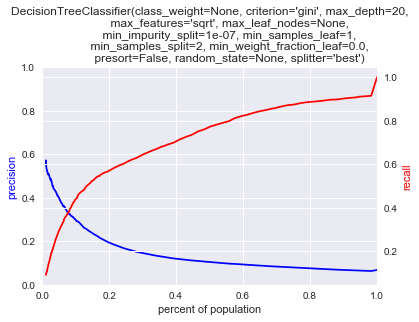

parameters
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


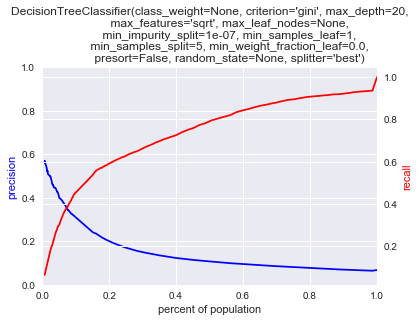

parameters
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


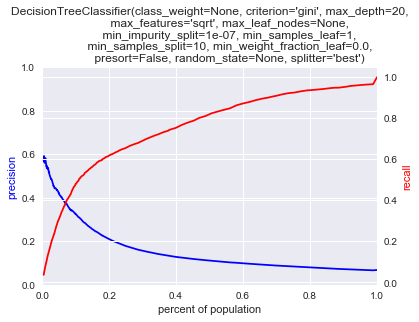

parameters
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


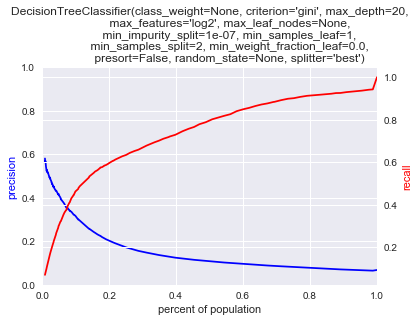

parameters
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


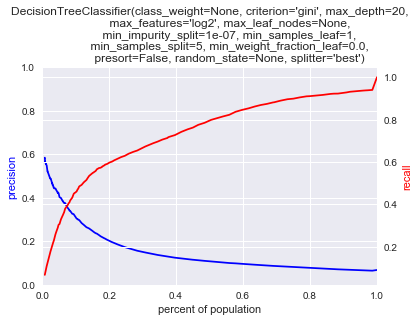

parameters
{'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


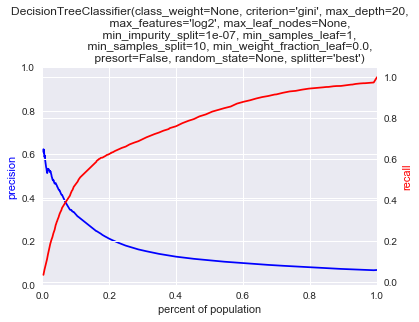

parameters
{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


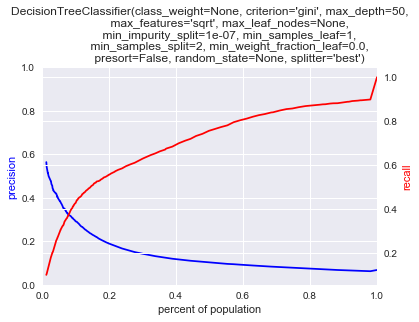

parameters
{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


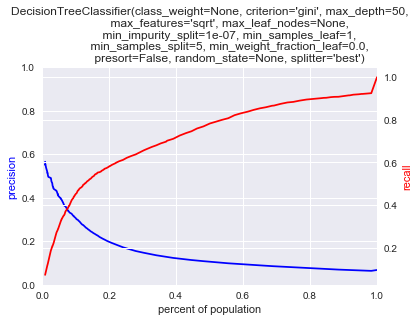

parameters
{'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


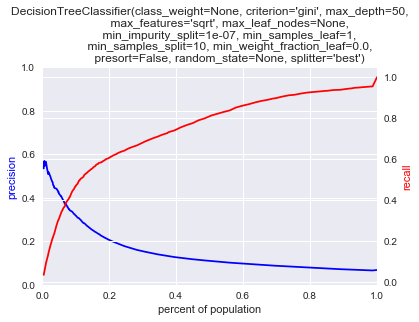

parameters
{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


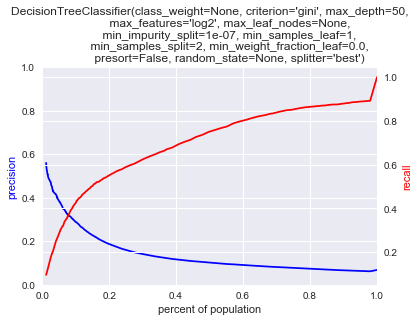

parameters
{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


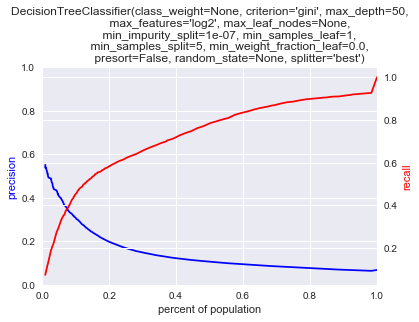

parameters
{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


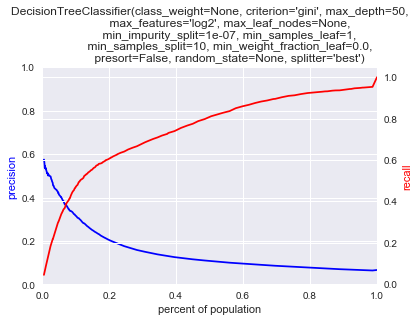

parameters
{'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


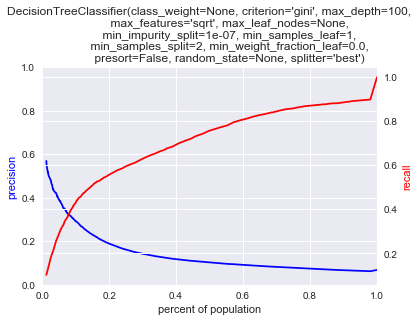

parameters
{'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


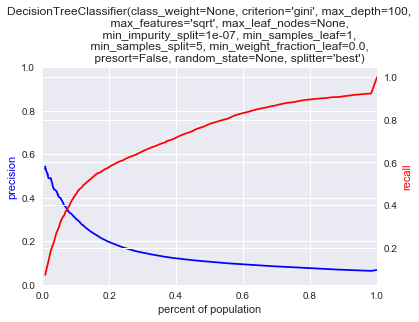

parameters
{'criterion': 'gini', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


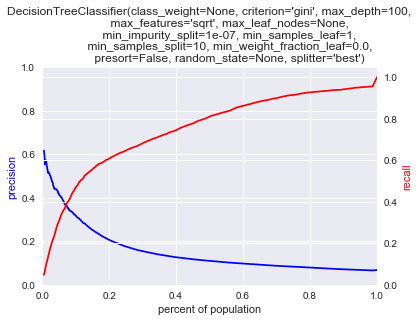

parameters
{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


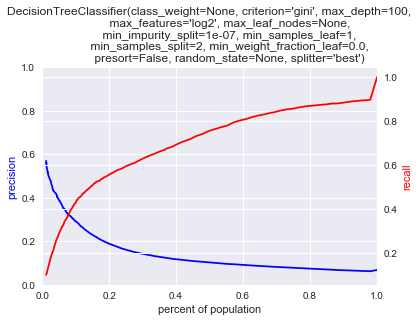

parameters
{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


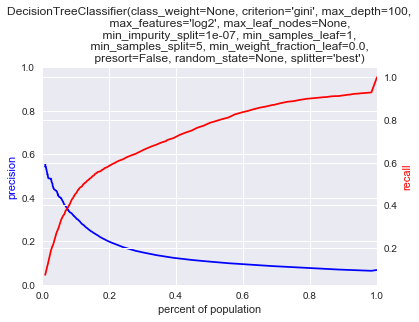

parameters
{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


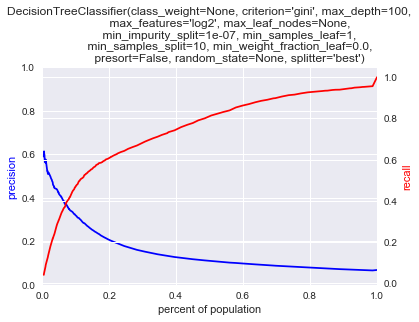

parameters
{'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


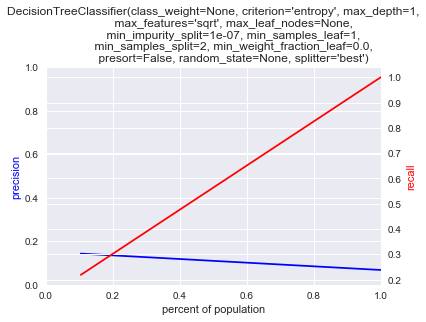

parameters
{'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


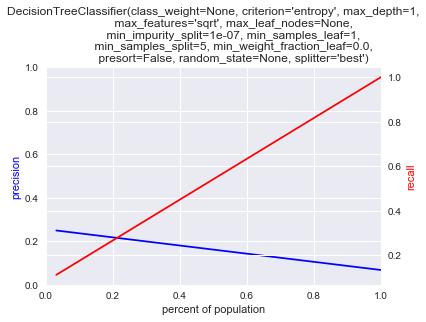

parameters
{'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


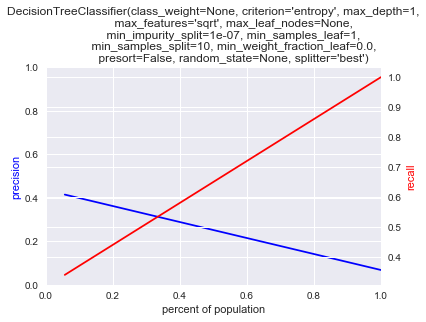

parameters
{'criterion': 'entropy', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


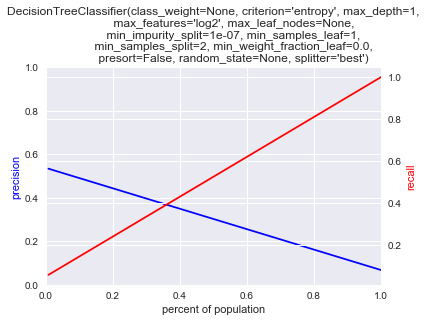

parameters
{'criterion': 'entropy', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


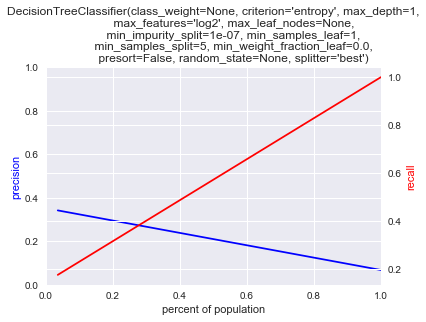

parameters
{'criterion': 'entropy', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


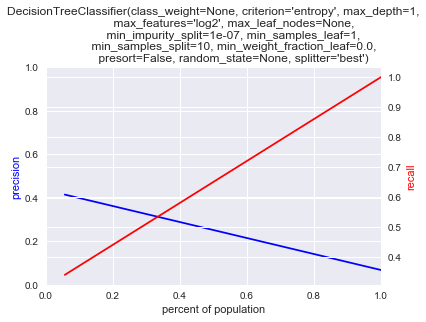

parameters
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


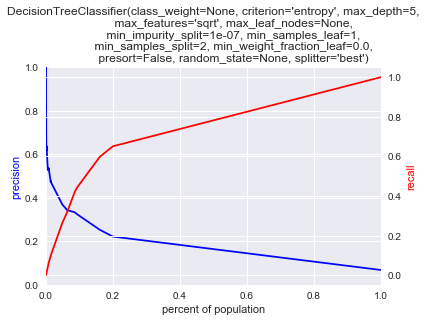

parameters
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


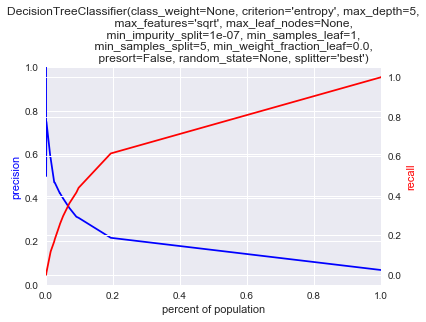

parameters
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


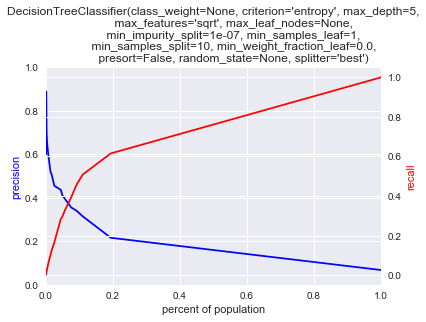

parameters
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


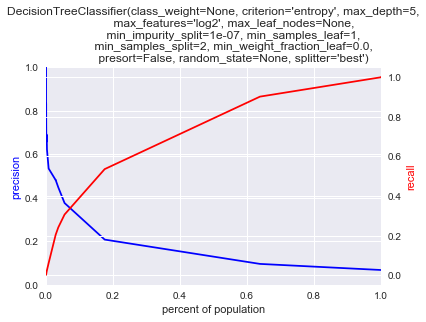

parameters
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


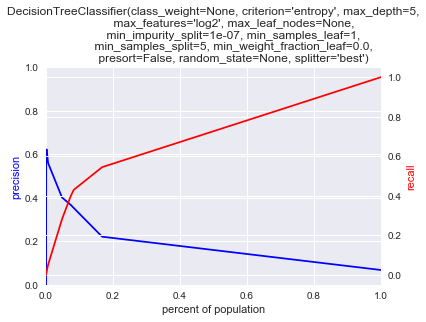

parameters
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


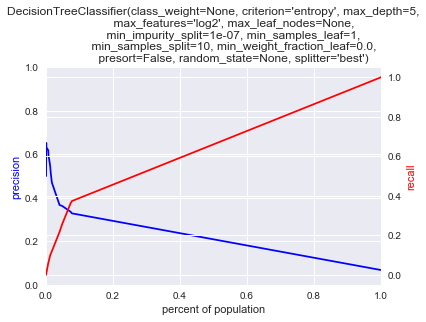

parameters
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


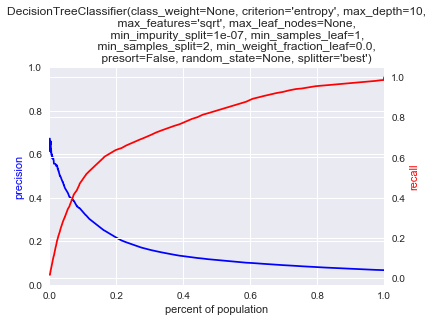

parameters
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


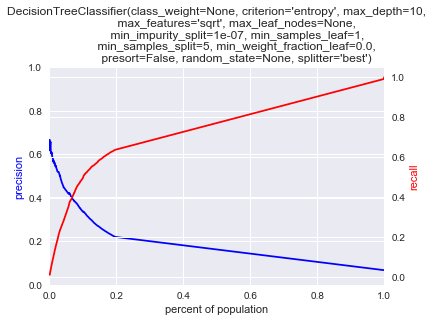

parameters
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


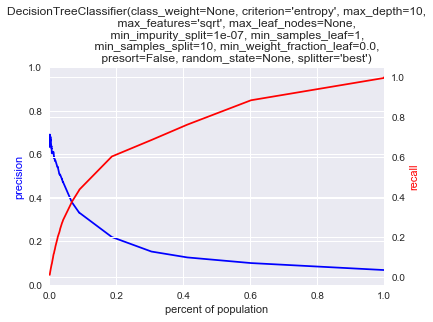

parameters
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


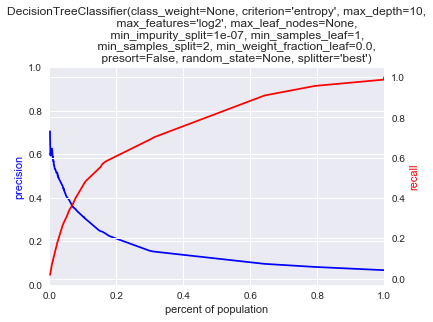

parameters
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


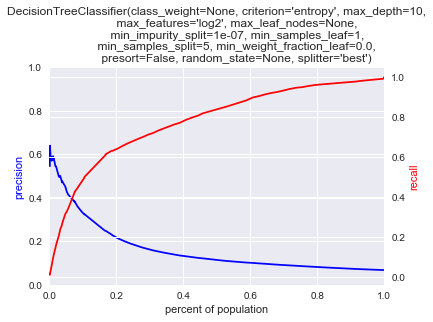

parameters
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


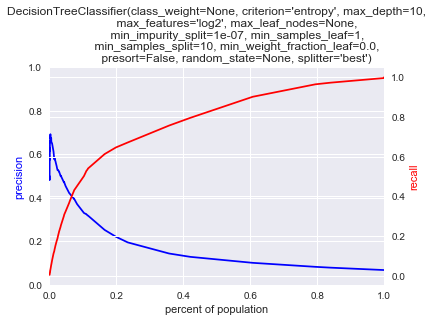

parameters
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


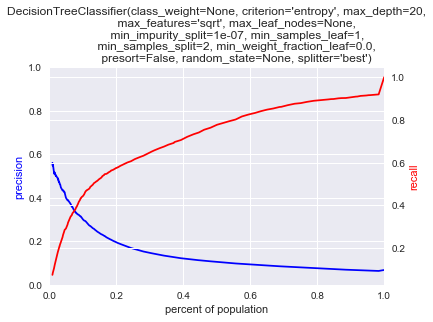

parameters
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


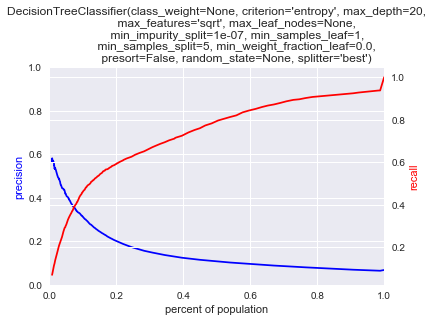

parameters
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


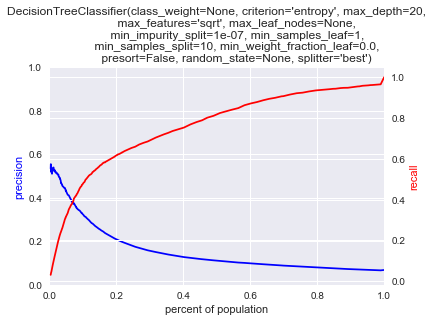

parameters
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


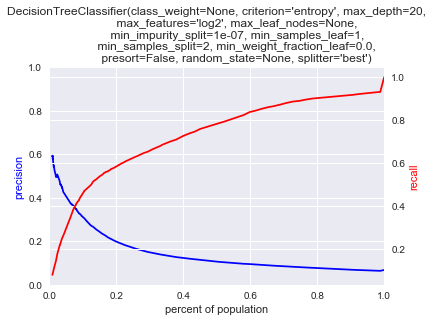

parameters
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


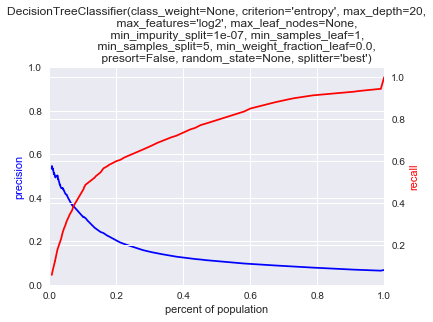

parameters
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


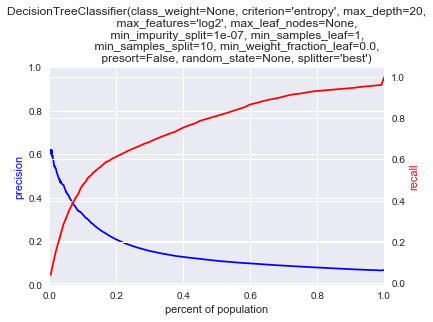

parameters
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


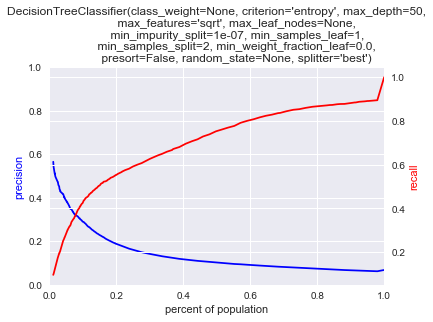

parameters
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


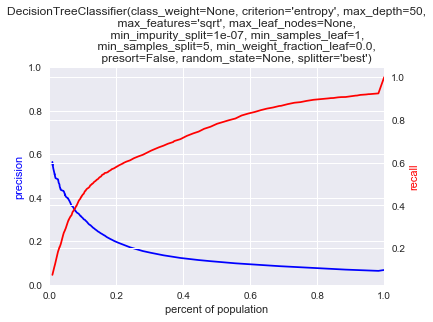

parameters
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


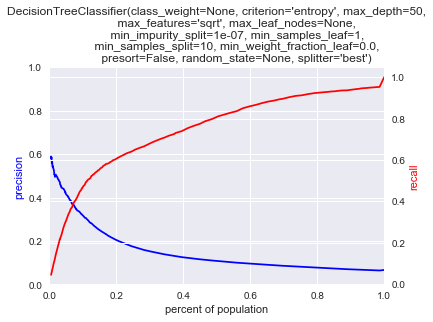

parameters
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


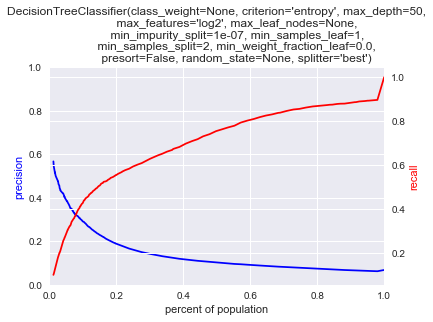

parameters
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


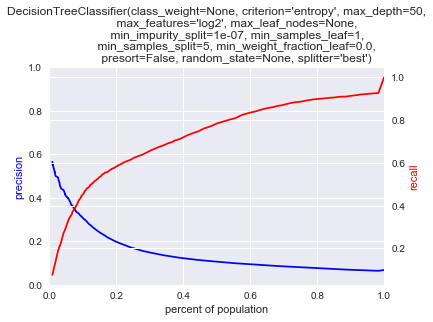

parameters
{'criterion': 'entropy', 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


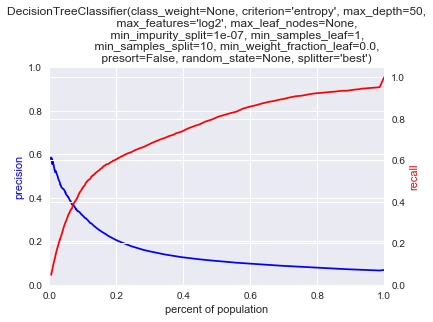

parameters
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 2}
37500
37500


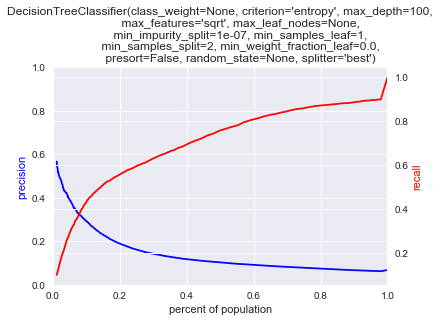

parameters
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 5}
37500
37500


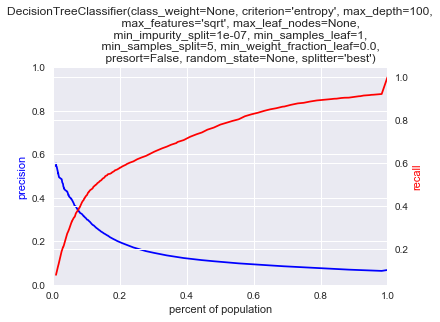

parameters
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 10}
37500
37500


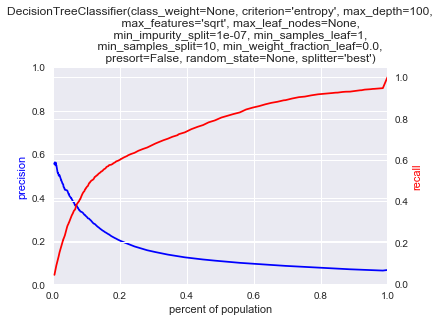

parameters
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 2}
37500
37500


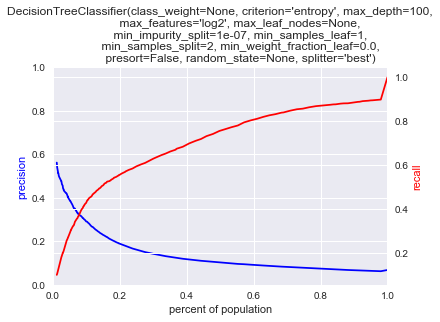

parameters
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 5}
37500
37500


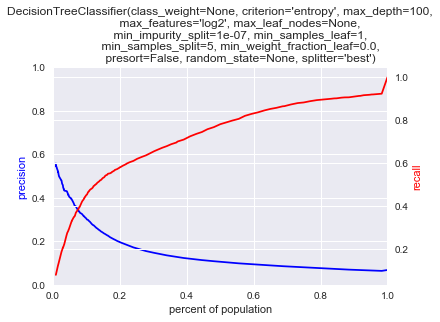

parameters
{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'min_samples_split': 10}
37500
37500


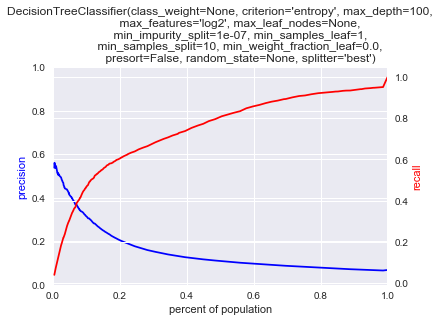

clf
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
parameters
{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}
37500
37500


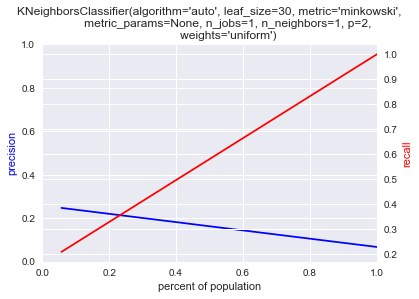

parameters
{'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'distance'}
37500
37500


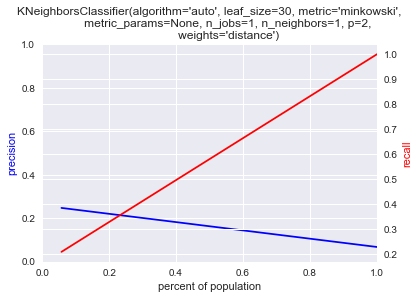

parameters
{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
37500
37500


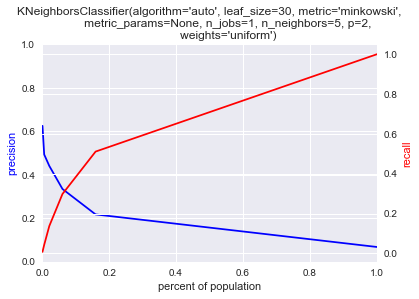

parameters
{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
37500
37500


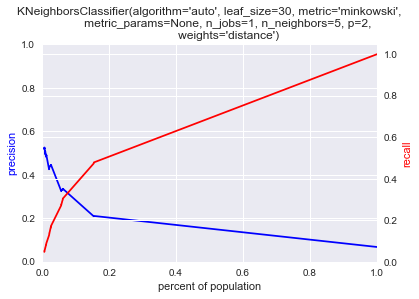

parameters
{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
37500
37500


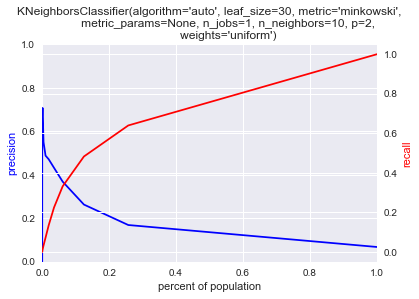

parameters
{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
37500
37500


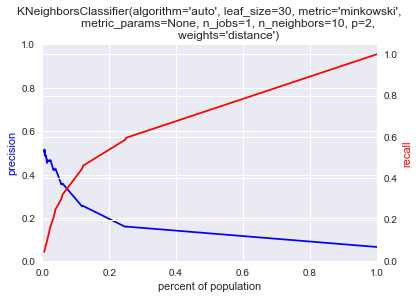

parameters
{'algorithm': 'auto', 'n_neighbors': 25, 'weights': 'uniform'}
37500
37500


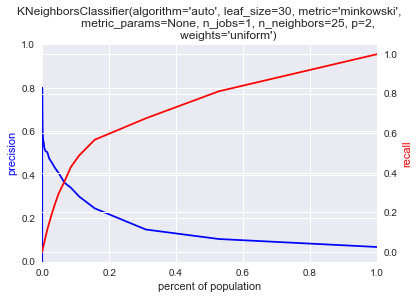

parameters
{'algorithm': 'auto', 'n_neighbors': 25, 'weights': 'distance'}
37500
37500


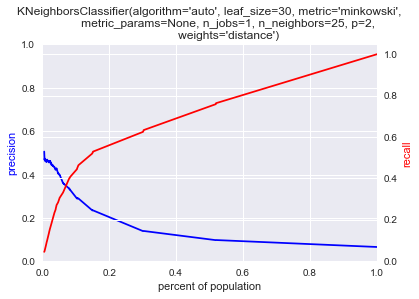

parameters
{'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'uniform'}
37500
37500


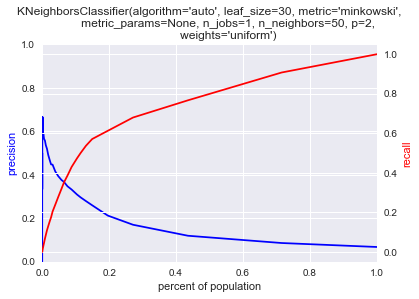

parameters
{'algorithm': 'auto', 'n_neighbors': 50, 'weights': 'distance'}
37500
37500


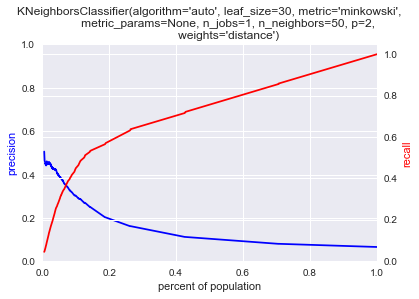

parameters
{'algorithm': 'auto', 'n_neighbors': 100, 'weights': 'uniform'}
37500
37500


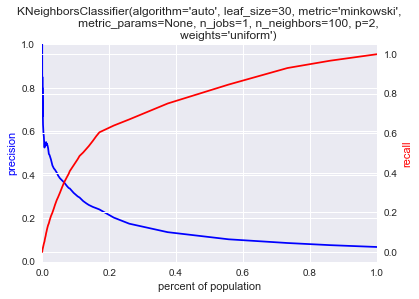

parameters
{'algorithm': 'auto', 'n_neighbors': 100, 'weights': 'distance'}
37500
37500


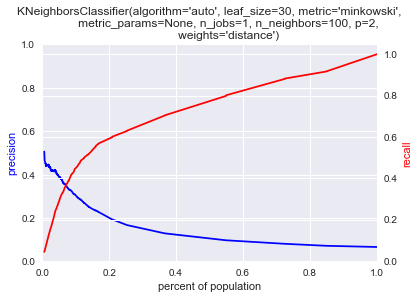

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'uniform'}
37500
37500


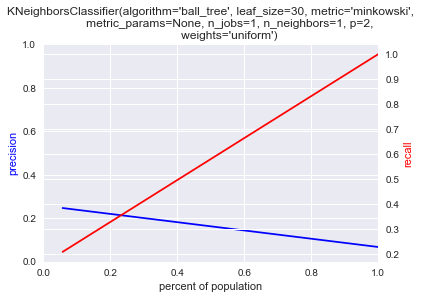

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'weights': 'distance'}
37500
37500


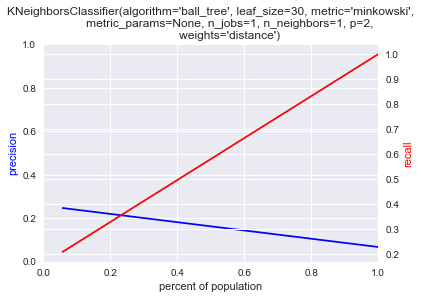

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'uniform'}
37500
37500


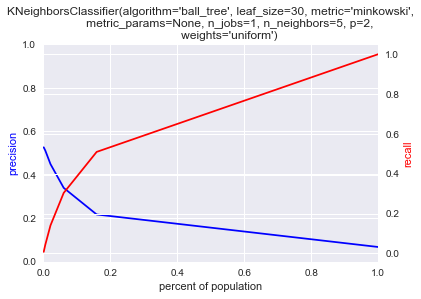

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
37500
37500


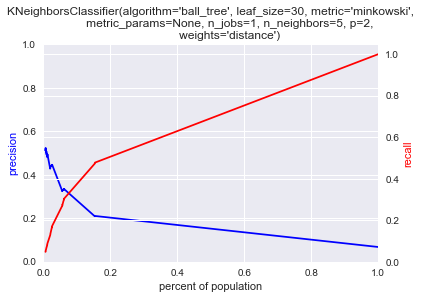

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}
37500
37500


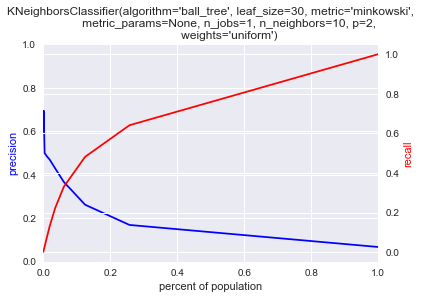

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}
37500
37500


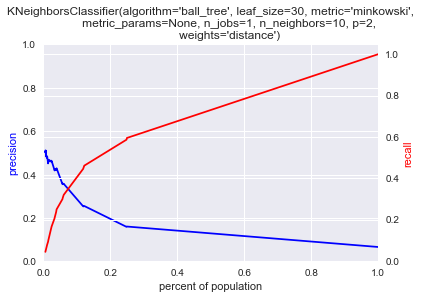

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 25, 'weights': 'uniform'}
37500
37500


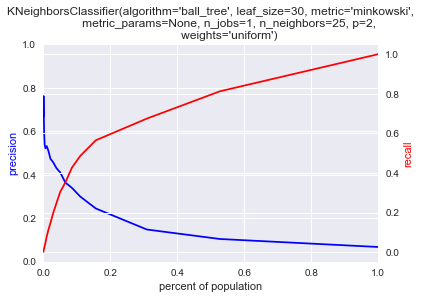

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 25, 'weights': 'distance'}
37500
37500


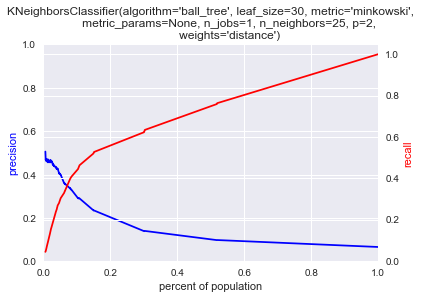

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'weights': 'uniform'}
37500
37500


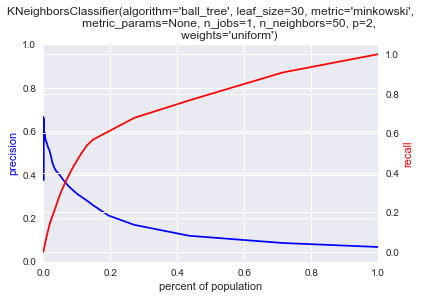

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 50, 'weights': 'distance'}
37500
37500


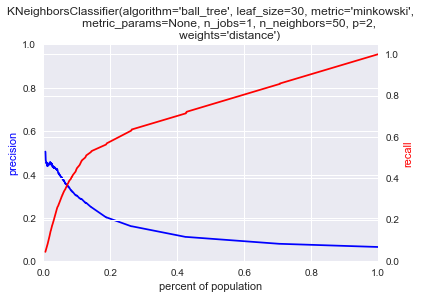

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 100, 'weights': 'uniform'}
37500
37500


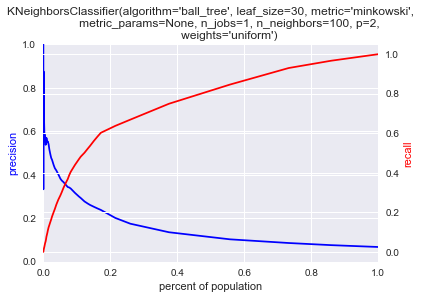

parameters
{'algorithm': 'ball_tree', 'n_neighbors': 100, 'weights': 'distance'}
37500
37500


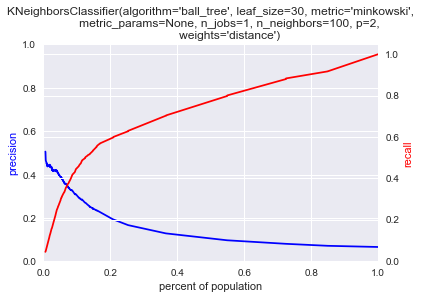

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 1, 'weights': 'uniform'}
37500
37500


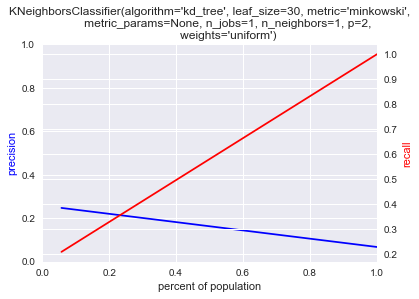

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 1, 'weights': 'distance'}
37500
37500


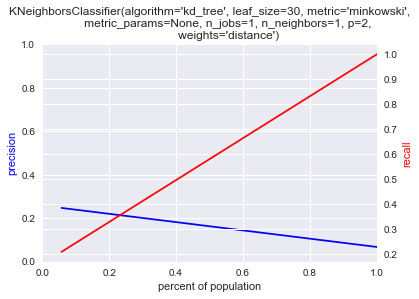

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'uniform'}
37500
37500


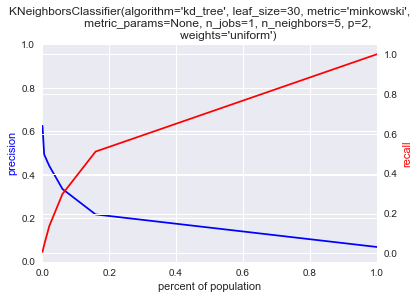

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'distance'}
37500
37500


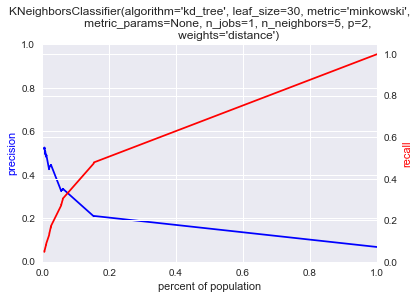

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'uniform'}
37500
37500


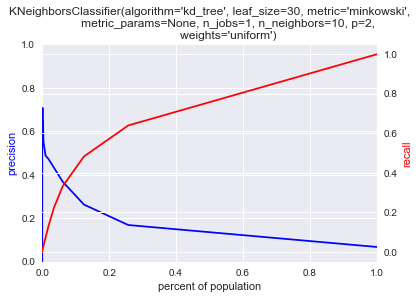

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'distance'}
37500
37500


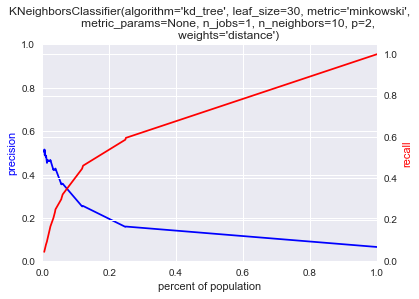

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 25, 'weights': 'uniform'}
37500
37500


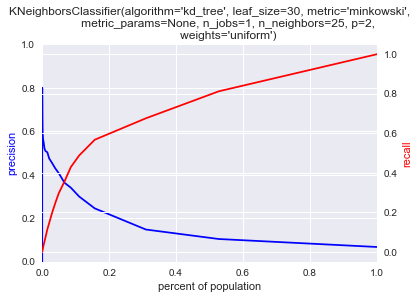

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 25, 'weights': 'distance'}
37500
37500


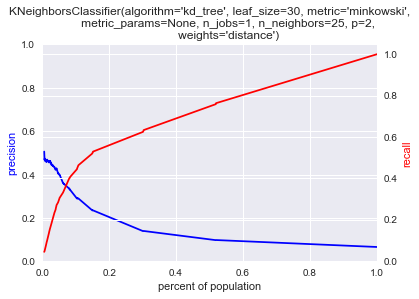

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 50, 'weights': 'uniform'}
37500
37500


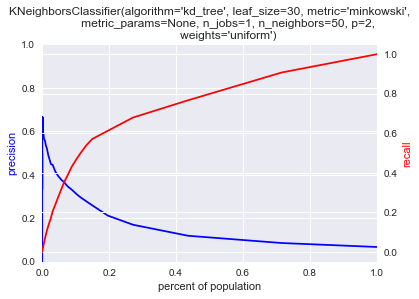

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 50, 'weights': 'distance'}
37500
37500


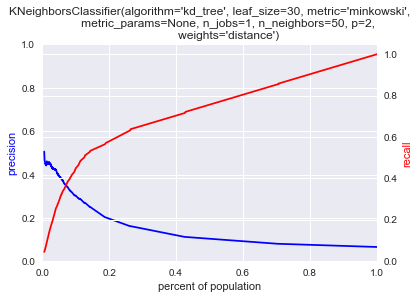

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 100, 'weights': 'uniform'}
37500
37500


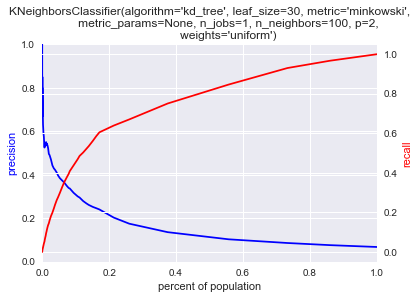

parameters
{'algorithm': 'kd_tree', 'n_neighbors': 100, 'weights': 'distance'}
37500
37500


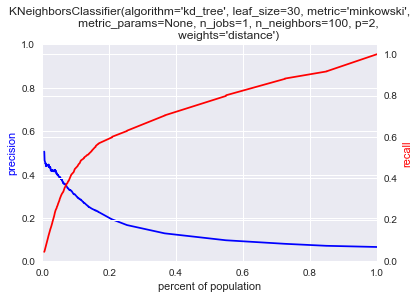

clf
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=0.65,
         n_estimators=5, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)
parameters
{'max_features': 1.0, 'max_samples': 0.65, 'n_estimators': 5}
37500
37500


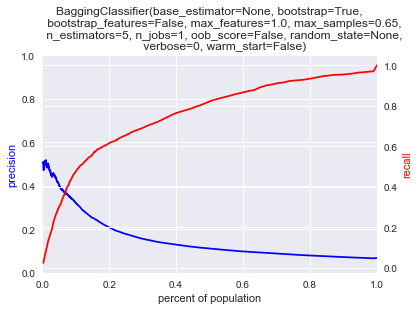

parameters
{'max_features': 1.0, 'max_samples': 0.65, 'n_estimators': 8}
37500
37500


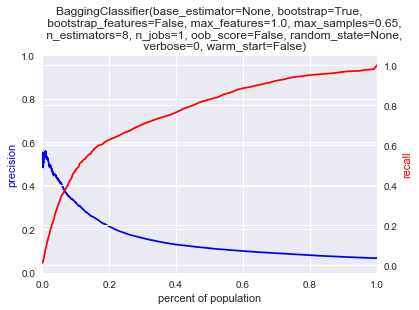

parameters
{'max_features': 1.0, 'max_samples': 0.65, 'n_estimators': 10}
37500
37500


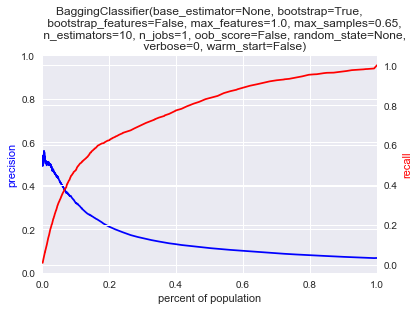

parameters
{'max_features': 1.0, 'max_samples': 0.65, 'n_estimators': 15}
37500
37500


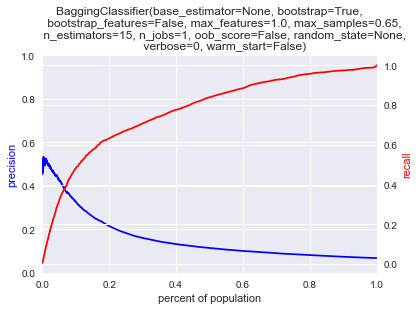

parameters
{'max_features': 1.0, 'max_samples': 1, 'n_estimators': 5}
37500
37500


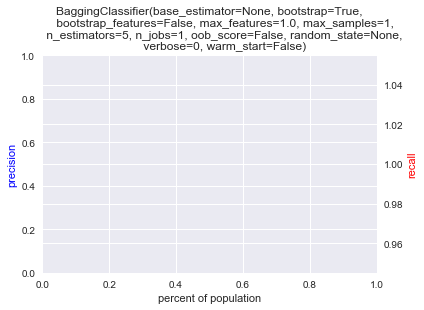

parameters
{'max_features': 1.0, 'max_samples': 1, 'n_estimators': 8}
37500
37500


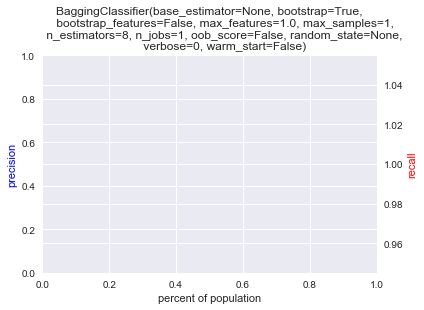

parameters
{'max_features': 1.0, 'max_samples': 1, 'n_estimators': 10}
37500
37500


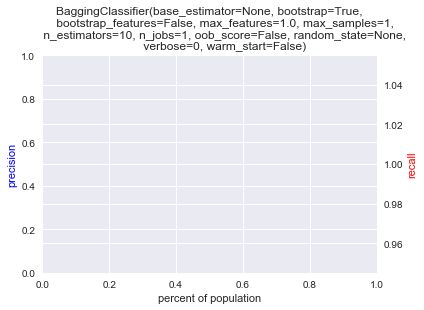

parameters
{'max_features': 1.0, 'max_samples': 1, 'n_estimators': 15}
37500
37500


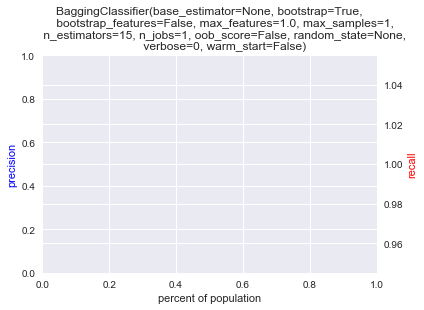

In [221]:
X,y = pre_process_data(X,y,credit_df,list_dummies)
y = y.SeriousDlqin2yrs
results_df = results(X,y)



### Please read the report "Financial_Distress.pdf" for a discussion of the results

Thank you for your time.

Pedro Armengol